# PubMedQA: A Dataset for Biomedical Research Question Answering

Group: TLDR

Federica Maria Laudizi, Margherita Marino, Tomaz Maia Suller, Francesca Visalli

**Link to video:** https://www.youtube.com/watch?v=hmMwgnciTtU

This notebook focuses on the PubMedQA dataset, it analizes it and performs classification tasks over it through several different models and techniques. Eventually, it branches onto some possible extensions related to the dataset and task at hand.

This notebook presents an implementation and analysis based on the research [research paper](https://arxiv.org/abs/1909.06146) titled **"PubMedQA: A Dataset for Biomedical Research Question Answering"** by Qiao Jin, Bhuwan Dhingra, Zhengping Liu, William W. Cohen, Xinghua Lu, published in 2019. The goal of this notebook is to reproduce and explore the key concepts, methods, and results described in the paper, providing a practical perspective on the approach.
Most code, visualizations, and experiments have been developed to align closely with the methodology described in the paper, with slight modifications where necessary for clarity or technical compatibility.

Some of the models we chose for fine tuning come from the dedicated PubMedQA leaderboard published at https://pubmedqa.github.io/ or from the paper cited above. In particular, from the leaderboard we chose the DRAGON model because of its good tradeoff between number of parameters and performance.

For the DRAGON model and the two-phase fine tuning of BERT, we decided to apply the strategy proposed in the paper cited above. It consists in using the long answer only as additional information during training but not at inference time. In particular, we confronted how their performance differed using and not using the long answer at inference time. This was done to reproduce the fact that when labelling the labeled part of the PubMedQA dataset, only 212 doctors had the long answer at their disposal.
When we applied this to our top performing model, we could notice a big drop in performance.


## Set up

### Library imports and necessary installations

In [ ]:
import itertools
import re
import pickle
import os
from collections import defaultdict, Counter
from pathlib import Path
from functools import partial
from random import sample
from string import punctuation

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

import umap.umap_ as umap
from datasets import Dataset
from IPython.display import Markdown, display
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from numpy.lib.npyio import NpzFile
from scipy.cluster.hierarchy import dendrogram
from scipy.sparse import csr_matrix

from sentence_transformers import SentenceTransformer
from sklearn.cluster import HDBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
)
from sklearn.cluster import KMeans

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import (
    AutoConfig,
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BertForSequenceClassification,
    BertTokenizer,
    Trainer,
    TrainingArguments,
)
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from collections import Counter

import os
import pickle
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt_tab")

In [ ]:
sns.set_theme()

### Helper functions

Data loading

In [ ]:
def yes_no_maybe_to_bool(string: str) -> bool | None:
    string = string.lower().strip()
    if string == "yes":
        return True
    elif string == "no":
        return False
    elif string == "maybe":
        return None
    raise ValueError(f"Unrecognised value `{string}`")

When loading, we:

1. Flatten the dataset so all `context` fields are accessible as columns of the `DataFrame` with a `context.` prefix
2. Convert answers from `str` to `bool`, using `None` to represent "maybe"s
3. Join context fields into `context.full_context`, and MeSHes into `context.full_meshes`
4. Create two new columns to be used as model input:
    * `full_text`, which joins `question`, `context.full_context`, `long_answer` and `context.full_meshes`
    * `no_reasoning`, which joins all columns in `full_text` except for `long_answer`
5. Set `pubid` as index
6. Save final `DataFrame` into local cache so we may not make a new network request and reprocess the dataset if we execute the notebook again

Step number 4 aims to reproduce the conditions introduced in the paper, in which one of the human labellers was given the conclusion, while another was not. Therefore, we store both to allow us to choose later on.

In [ ]:
def load(partition: str) -> pd.DataFrame:
    if (cache_path := Path(f".cache-{partition}.parquet")).exists():
        return pd.read_parquet(cache_path)
    df = pd.read_parquet(
        f"hf://datasets/qiaojin/PubMedQA/pqa_{partition}/train-00000-of-00001.parquet"
    )
    # Normalise context.str.split(expand=True)
    context = df.pop("context")
    df = df.join(pd.json_normalize(context).add_prefix("context."))
    # Turn reasoning from list of chars into string
    reasoning_df = df.filter(like="reasoning")
    df = df.drop(columns=reasoning_df.columns)
    df = df.join(reasoning_df.map("".join))

    if "final_decision" in df.columns:
        try:
            bool_str_df = df[
                [
                    "context.reasoning_required_pred",
                    "context.reasoning_free_pred",
                    "final_decision",
                ]
            ]
        except KeyError:
            bool_str_df = df["final_decision"].to_frame()
        bool_df = bool_str_df.map(yes_no_maybe_to_bool)

        for column in bool_df.columns:
            df[column] = bool_df[column]
            df[f"{column}_str"] = bool_str_df[column]

    df["context.full_context"] = df["context.contexts"].apply(" ".join)
    df["context.full_meshes"] = df["context.meshes"].apply("; ".join)
    full_text_series = df["question"]
    no_reasoning_series = df["question"]
    for column in ("context.full_context", "long_answer", "context.full_meshes"):
        full_text_series = full_text_series.str.cat(df[column], sep=" ")
        if column == "long_answer":
            continue
        no_reasoning_series = no_reasoning_series.str.cat(df[column], sep=" ")
    df["full_text"] = full_text_series
    df["no_reasoning"] = no_reasoning_series

    df = df.set_index("pubid")

    df = df.convert_dtypes()

    df.to_parquet(cache_path)

    return df

Analysis

In [ ]:
def plot_top_n_count(
    series: pd.Series,
    n: int = 20,
    normalise: bool = False,
    plot_others: bool = True,
    **plot_kwargs,
):
    count = series.value_counts()
    top_count = count[:n].copy()
    if plot_others:
        top_count["OTHERS"] = count[n:].sum()
    if normalise:
        top_count /= top_count.sum()
    return top_count.plot.barh(**plot_kwargs)

In [ ]:
def plot_cluster_corpus_word_counts(df: pd.DataFrame, corpus_count, top_n: int = 20, **barplot_kwargs):
    cluster_top_count = df["full_text_words"].value_counts(normalize=True)[:top_n]
    corpus_cluster_top_count = corpus_count[cluster_top_count.index]

    cluster_top_count_df = cluster_top_count.to_frame()
    cluster_top_count_df["set"] = "cluster"
    corpus_cluster_top_count_df = corpus_cluster_top_count.to_frame()
    corpus_cluster_top_count_df["set"] = "corpus"

    top_count_df = pd.concat(
        [cluster_top_count_df, corpus_cluster_top_count_df]
    ).reset_index()
    ax = sns.barplot(
        top_count_df,
        x="proportion",
        y="full_text_words",
        hue="set",
        **barplot_kwargs
    )
    return ax

In [ ]:
def sklearn_hierarchical_linkage(model: AgglomerativeClustering) -> np.ndarray:
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

In [ ]:
def plot_dendrogram(model: AgglomerativeClustering, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = sklearn_hierarchical_linkage(model)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
def svd_tsne(
    input_,
    svd_components: int = 100,
    tsne_components: int = 2,
    seed: int = 42,
):
    svd = TruncatedSVD(n_components=svd_components, random_state=seed)
    tsne = TSNE(n_components=tsne_components, random_state=seed)
    result = tsne.fit_transform(svd.fit_transform(input_))
    return pd.DataFrame(
        result,
        columns=[f"tsne_{i}" for i in range(result.shape[1])],
    )

Embedding similarity

In [ ]:
def compute_embedding_similarities(x, y) -> tuple[np.ndarray, np.ndarray]:
    similarity = x @ y.T
    self_similarity = similarity.diagonal()
    if isinstance(similarity, np.ndarray):
        np.fill_diagonal(similarity, 0)
    elif isinstance(similarity, csr_matrix):
        similarity.setdiag(0)
    else:
        raise NotImplementedError(f"Unsupported type `{type(similarity)}`")
    cross_similarity = np.array(
        similarity.sum(axis=0) / (similarity.shape[0] - 1)
    ).squeeze()
    return self_similarity, cross_similarity

In [ ]:
def compute_embedding_distances(x, y) -> np.ndarray:
    return np.linalg.norm(x - y, axis=1)

### Load data

In [ ]:
labeled_df = load("labeled")
artificial_df = load("artificial")
unlabeled_df = load("unlabeled")

The creators of the dataset also provide the train-test split employed to compute metrics for the leaderboard through a JSON containing `pubid`s and their respective ground truth labels.

In [ ]:
test_set: pd.Series = pd.read_json(
    "https://raw.githubusercontent.com/pubmedqa/pubmedqa/refs/heads/master/data/test_ground_truth.json",
    typ="series",
    dtype="string",
)
test_set.name = "test_ground_truth"
test_set

12377809      yes
26163474      yes
19100463      yes
18537964      yes
12913878      yes
            ...  
17691856    maybe
16735905    maybe
19694846    maybe
25007420    maybe
26134053    maybe
Name: test_ground_truth, Length: 500, dtype: string

According to the paper, the paper, 500 of 1000 samples from the labelled dataset are used for testing. Therefore, we expect 500 labelled samples in the test set, 500 in the train set, and that no sample in the test set is also in teh train set. Those conditions are verified using assertions.

In [ ]:
test_df = labeled_df.join(test_set, how="inner")
labeled_train_set = labeled_df.loc[labeled_df.index.difference(test_set.index)]

assert test_df.shape[0] == 500  # noqa: S101
assert labeled_train_set.shape[0] == 500  # noqa: S101
assert not (labeled_train_set.index.isin(test_df.index)).any()  # noqa: S101

In [ ]:
labeled_train_set

question  \
1571683   Storage of vaccines in the community: weak lin...   
2224269   Should general practitioners call patients by ...   
2503176   Inhibin: a new circulating marker of hydatidif...   
8017535   Substance use and HIV-related sexual behaviors...   
8111516   Do family physicians make good sentinels for i...   
...                                                     ...   
28011794  Can Ambu self-inflating bag and Neopuff infant...   
28027677  Do prerecorded lecture VODcasts affect lecture...   
28127977  Are serum leptin levels a prognostic factor in...   
28177278  Does spontaneous remission occur in polyarteri...   
28407529  Resection of colorectal liver metastases after...   

                                                long_answer  final_decision  \
1571683   Vaccines were exposed to temperatures that may...            <NA>   
2224269   General practitioners should consider using pa...            True   
2503176   In this small study serum inhibin concentratio...            True   
8017535   HIV prevention programs for youth should recog...            True   
8111516   Family physicians provide sensitive, timely, a...            True   
...                                                     ...             ...   
28011794  The Ambu SIB was able to accurately deliver ta...            <NA>   
28027677  Therefore, we conclude that the attendance of ...           False   
28127977  Our results showed that the serum leptin level...           False   
28177278  This case illustrates the importance of consid...            True   
28407529  CLM resection following second-line PCT, after...           False   

                                           context.contexts  \
1571683   [To assess quality of storage of vaccines in t...   
2224269   [To assess the acceptability to patients of th...   
2503176   [To define the concentrations of inhibin in se...   
8017535   [This study was undertaken to examine whether ...   
8111516   [To determine whether volunteer family physici...   
...                                                     ...   
28011794  [Manual resuscitation devices for infants and ...   
28027677  [There is increasing concern amongst educators...   
28127977  [There are 71 previously untreated patients wi...   
28177278  [Polyarteritis nodosa (PAN) is a systemic vasc...   
28407529  [Patient outcome after resection of colorectal...   

                                             context.labels  \
1571683   [OBJECTIVE, DESIGN, SETTING, SUBJECTS, MAIN OU...   
2224269   [OBJECTIVE, DESIGN, SETTING, PATIENTS, MAIN OU...   
2503176   [OBJECTIVE, DESIGN, SETTING, PATIENTS, END POI...   
8017535                      [OBJECTIVES, METHODS, RESULTS]   
8111516   [OBJECTIVE, DESIGN, SETTING, PARTICIPANTS, INT...   
...                                                     ...   
28011794                     [BACKGROUND, METHODS, RESULTS]   
28027677                     [BACKGROUND, METHODS, RESULTS]   
28127977                    [MATERIAL AND METHODS, RESULTS]   
28177278                         [BACKGROUND, PRESENTATION]   
28407529           [PURPOSE, PATIENTS AND METHODS, RESULTS]   

                                             context.meshes  \
1571683   [Child, Child Health Services, Drug Storage, F...   
2224269   [Adolescent, Adult, Age Factors, Aged, Attitud...   
2503176   [Adolescent, Adult, Biomarkers, Tumor, Chorion...   
8017535   [Adolescent, Adolescent Behavior, Cross-Sectio...   
8111516   [Adolescent, Adult, Aged, Centers for Disease ...   
...                                                     ...   
28011794  [Equipment Design, Female, Humans, Infant Care...   
28027677  [Adult, Education, Medical, Undergraduate, Fem...   
28127977  [Aged, Biomarkers, Tumor, Body Mass Index, Fem...   
28177278  [Cyclophosphamide, Diagnosis, Differential, Fe...   
28407529  [Antibodies, Monoclonal, Antineoplastic Combin...   

          context.reasoning_required_pred  context.reasoning_free_pred  \


### Paths

In [ ]:
ROOT_PATH = Path()
SENTENCE_EMBEDDINGS_PATH = ROOT_PATH / "embeddings" / "sentence" / "labeled"
LLM_OUTPUT_ROOT_DIR = ROOT_PATH / "outputs"

## Preliminary analysis

For preliminary analysis, we access all `DataFrame`s, so having them in an indexable format and all together in a single object is helpful

In [ ]:
data_dfs = {
    "labeled": labeled_df,
    "artificial": artificial_df,
    "unlabeled": unlabeled_df,
}

In [ ]:
pubmedqa_df_list = []
for dataset, df in data_dfs.items():
    df_to_merge = df.copy()
    df_to_merge["dataset"] = dataset
    pubmedqa_df_list.append(df_to_merge)
pubmedqa_df = pd.concat(pubmedqa_df_list)
pubmedqa_df

question  \
pubid                                                         
21645374  Do mitochondria play a role in remodelling lac...   
16418930  Landolt C and snellen e acuity: differences in...   
9488747   Syncope during bathing in infants, a pediatric...   
17208539  Are the long-term results of the transanal pul...   
10808977  Can tailored interventions increase mammograph...   
...                                                     ...   
10632750  Diversion colitis in children: an iatrogenic a...   
10632796  Raising research awareness among midwives and ...   
10632828  Delivery of primary care to women. Do women's ...   
10633786  Analysis of failures after whole abdominal irr...   
10634050  Loco-regional block in ophthalmic surgery: sin...   

                                                long_answer  final_decision  \
pubid                                                                         
21645374  Results depicted mitochondrial dynamics in viv...            True   
16418930  Using the charts described, there was only a s...           False   
9488747   "Aquagenic maladies" could be a pediatric form...            True   
17208539  Our long-term study showed significantly bette...           False   
10808977  The effects of the intervention were most pron...            True   
...                                                     ...             ...   
10632750  Histological features of DC in children are ve...            <NA>   
10632796  The introduction of clinical governance challe...            <NA>   
10632828  These results suggest that, at least in this s...            <NA>   
10633786  General prophylactic enclosure of the inguinal...            <NA>   
10634050  Local anaesthetics mixture with hyaluronidase ...            <NA>   

                                           context.contexts  \
pubid                                                         
21645374  [Programmed cell death (PCD) is the regulated ...   
16418930  [Assessment of visual acuity depends on the op...   
9488747   [Apparent life-threatening events in infants a...   
17208539  [The transanal endorectal pull-through (TERPT)...   
10808977  [Telephone counseling and tailored print commu...   
...                                                     ...   
10632750  [Diversion colitis (DC) is a localized, relati...   
10632796  [The primary aim of the study was to evaluate ...   
10632828  [Women's health centers have been increasing i...   
10633786  [To evaluate failures and to investigate the n...   
10634050  [The aim of this study is the comparison betwe...   

                                             context.labels  \
pubid                                                         
21645374                              [BACKGROUND, RESULTS]   
16418930        [BACKGROUND, PATIENTS AND METHODS, RESULTS]   
9488747                          [BACKGROUND, CASE REPORTS]   
17208539                        [PURPOSE, METHODS, RESULTS]   
10808977  [BACKGROUND, DESIGN, PARTICIPANTS, INTERVENTIO...   
...                                                     ...   
10632750                        [AIMS, METHODS AND RESULTS]   
10632796  [OBJECTIVE, DESIGN, SAMPLE, ETHICS, DATA COLLE...   
10632828  [OBJECTIVE, DESIGN, SETTING, PARTICIPANTS, MEA...   
10633786         [BACKGROUND, PATIENTS AND METHOD, RESULTS]   
10634050                              [UNLABELLED, RESULTS]   

                                             context.meshes  \
pubid                                                         
21645374  [Alismataceae, Apoptosis, Cell Differentiation...   
16418930  [Adolescent, Adult, Aged, Aged, 80 and over, A...   
9488747   [Baths, Histamine, Humans, Infant, Syncope, Ur...   
17208539  [Child, Child, Preschool, Colectomy, Female, H...   
10808977  [Cost-Benefit Analysis, Female, Health Mainten...   
...                                                     ...   
10632750  [Appendix, Child, Preschool, Colitis, Colitis,...

### Brief description of the data

**What is the structure of the dataset? What type of task was the dataset collected for?**

**What type of documents does it contain?**

The PubMedQA dataset is a biomedical question answering dataset, whose data has been collected from PubMed abstracts.
It is comprised of 1k expert-annotated,61.2k unlabeled and 211.3k artificially generated Question-Answer instances.
Each of these is composed of a question which is derived from an article title, a context, formed by the abstract without the conclusion, a long answer, the conclusion of the abstract and a yes/no/maybe answer.

PubMedQA was designed to answer research question with yes/no/maybe.

The maybe label is only present into the labeled subset of the dataset, which is when two doctors could not agree on an answer.

**How many are there?**

In [ ]:
print("Number of documents per dataset")
for dataset, df in data_dfs.items():
    print(dataset.rjust(10), df.shape[0])

Number of documents per dataset
   labeled 1000
artificial 211269
 unlabeled 61249


**How long are they on average and
what is their distribution?**

We analize the labeled, artificial and unlabeled dataset separately.
We first consider the average lengths of different fields, then the distribution of the labels (if present) and the distribution of the lengths of the dataset fields.

Word count distribution per field 

labeled
----------------------------------------


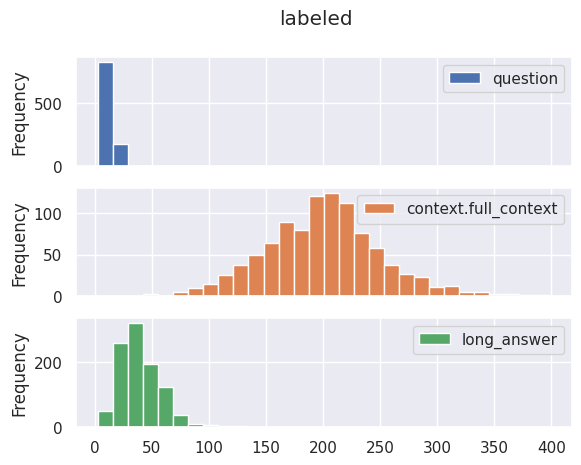

          question  context.full_context  long_answer
count  1000.000000           1000.000000  1000.000000
mean     12.913000            200.207000    39.660000
std       4.100518             51.846429    17.209432
min       3.000000             49.000000     8.000000
25%      10.000000            166.750000    27.000000
50%      13.000000            200.500000    37.000000
75%      15.000000            228.000000    49.000000
max      31.000000            398.000000   126.000000

artificial
----------------------------------------


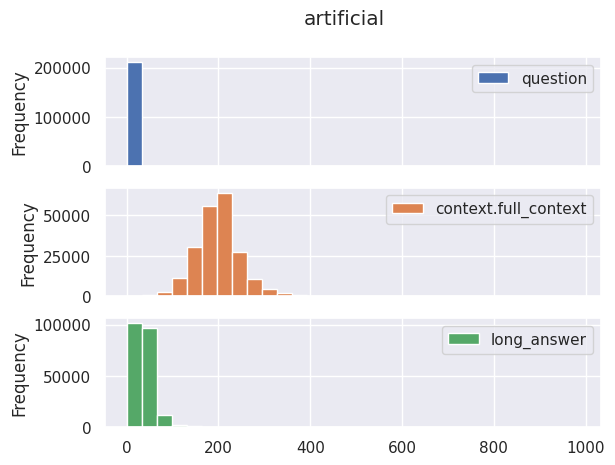

            question  context.full_context    long_answer
count  211269.000000         211269.000000  211269.000000
mean       15.344097            200.514207      37.593660
std         3.898447             50.708592      18.497014
min         3.000000              1.000000       1.000000
25%        13.000000            170.000000      25.000000
50%        15.000000            200.000000      34.000000
75%        17.000000            226.000000      46.000000
max       109.000000            983.000000     510.000000

unlabeled
----------------------------------------


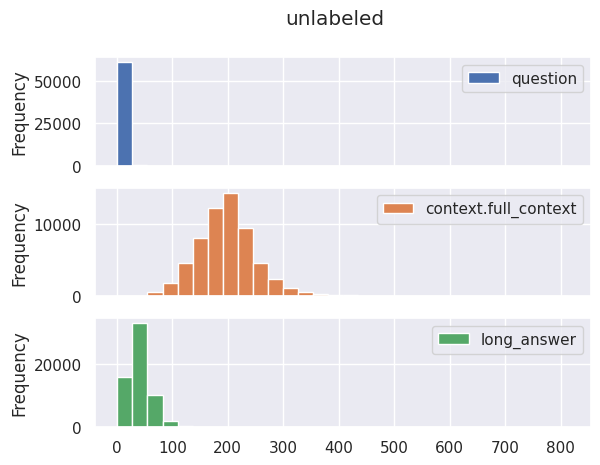

           question  context.full_context   long_answer
count  61249.000000          61249.000000  61249.000000
mean      13.345067            198.738902     42.023364
std        4.567044             56.654230     19.817240
min        2.000000             25.000000      1.000000
25%       10.000000            164.000000     28.000000
50%       13.000000            197.000000     39.000000
75%       16.000000            227.000000     52.000000
max       47.000000            814.000000    412.000000



In [ ]:
print("Word count distribution per field", "\n")
for dataset, df in data_dfs.items():
    lengths_df = df[["question", "context.full_context", "long_answer"]].map(
        lambda string: len(string.split())
    )

    print(dataset)
    print("-" * 40)

    lengths_df.plot.hist(subplots=True, bins=30)
    plt.suptitle(dataset)
    plt.show()

    print(lengths_df.describe())
    print()

We can see that all the dataframes have the same average length for their fields.

Text(0.5, 0.98, 'Number of instances per label')

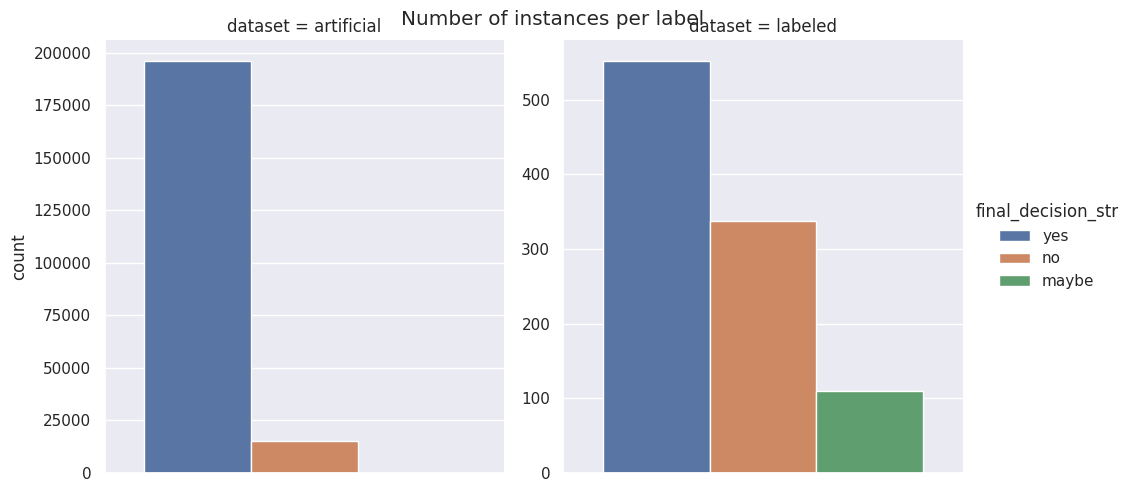

In [ ]:
g = sns.catplot(
    pubmedqa_df.groupby("dataset")["final_decision_str"].value_counts().reset_index(),
    kind="bar",
    hue="final_decision_str",
    col="dataset",
    y="count",
    sharey=False,
)
g.figure.suptitle("Number of instances per label")

We can see that, especially the artificial dataset, both artificial and labeled datasets have the majority of their elements belonging to the "yes" class. tThis can cause issues when trying to train a model which is capable of predicting correctly the negative class.

**How big is the vocabulary of the collection? How big is the vocabulary of a document on average?**

We consider the three subsets separately

In [ ]:
def vocabulary_size(text: str) -> int:
    return len(set(text.lower().split()))


pubmedqa_df["vocabulary_size"] = pubmedqa_df["full_text"].apply(vocabulary_size)

In [ ]:
print("Average vocabulary size per dataset")
pubmedqa_df.groupby("dataset")["vocabulary_size"].mean()

Average vocabulary size per dataset


dataset
artificial    162.752841
labeled       161.243000
unlabeled     162.405084
Name: vocabulary_size, dtype: float64

In [ ]:
print("Number of unique words per dataset", "\n")
pubmedqa_vocabulary = set()
for dataset, df in data_dfs.items():
    dataset_vocabulary = set()
    for document in df["full_text"]:
        dataset_vocabulary.update(document.lower().split())
    print(dataset.rjust(10), len(dataset_vocabulary))
    pubmedqa_vocabulary.update(dataset_vocabulary)
print("-" * 40)
print("overall".rjust(10), len(pubmedqa_vocabulary))

Number of unique words per dataset 

   labeled 33603
artificial 1246023
 unlabeled 486858
----------------------------------------
   overall 1484022


The vocabulary size is almost the same. This is to be expected as the articles and papers of origin all come from the same dataset of origin (PubMed) and they all deal with medical topics, so they are bound to contain words related to similar concepts. The number of unique words is much lower in the labeled dataset. This is to be expected since it is the smallest one.

### Further analysis
We now focus on analyzing further the artificially labeled dataset.

#### Labelled dataset normalisation

We employ NLTK for normalisation, including stemming and stop-word removal, and we remove punctuation.

Three custom stop-words are added, as they are not semantically relevant and make analysing term frequencies more difficult. They are

* "patient" (and its plural "patients in case it is not properly stemmed)
* "p", which would remain in expressions such as "p-value"

In [ ]:
DECIMAL_POINT_WITH_SPACE = re.compile(r"(\d)\s*\.\s*(\d)")

full_text_stop_words = set(
    [
        *stopwords.words("english"),
        "patient",
        "patients",
        "p",
    ]
)


def normalise_full_text(text: str) -> str:
    for symbol in "/.-'\"":
        text = text.replace(symbol, f" {symbol} ")
    # The previous rule will separate components of a decimal
    # number (e.g. x.y -> x . y) so we revert the change
    # if the components (x, y) are digits
    text = DECIMAL_POINT_WITH_SPACE.sub(r"\1.\2", text)
    text = text.lower()

    tokens = [
        token
        for token in word_tokenize(text)
        if token not in punctuation and token not in full_text_stop_words
    ]

    return " ".join(tokens)

Due to the lack of adequate computational resources, we perform full-text normalisation and in-depth analysis only in the labelled dataset, which is the smallest.

In [ ]:
df_to_normalise = labeled_df

bool_str_columns = df_to_normalise.columns[df_to_normalise.columns.str.endswith("_str")]
normalised_string_df: pd.DataFrame = (
    df_to_normalise.select_dtypes("string")
    .drop(columns=bool_str_columns)
    .map(normalise_full_text)
)
normalised_string_df

question  \
pubid                                                         
21645374  mitochondria play role remodelling lace plant ...   
16418930  landolt c snellen e acuity differences strabis...   
9488747   syncope bathing infants pediatric form water i...   
17208539  long term results transanal pull equal transab...   
10808977  tailored interventions increase mammography us...   
...                                                     ...   
8921484   gestational age misclassification explain diff...   
16564683  interest perform ultrasonography boys undescen...   
23147106  peak concentration needed therapeutic drug mon...   
21550158  autologous platelet rich plasma gel enhance he...   
17559449  sugars free medicines erosive sugars containin...   

                                                long_answer  \
pubid                                                         
21645374  results depicted mitochondrial dynamics vivo p...   
16418930  using charts described slight overestimation v...   
9488747   `` aquagenic maladies `` could pediatric form ...   
17208539  long term study showed significantly better 2 ...   
10808977  effects intervention pronounced first interven...   
...                                                     ...   
8921484   gestational age misclassification unlikely exp...   
16564683      sonography place diagnosis undescended testis   
23147106  results suggest little need use peak concentra...   
21550158  prp group recorded reduced pain swelling trism...   
17559449  paediatric sf medicines erosive sc medicines v...   

                                       context.full_context  \
pubid                                                         
21645374  programmed cell death pcd regulated death cell...   
16418930  assessment visual acuity depends optotypes use...   
9488747   apparent life threatening events infants diffi...   
17208539  transanal endorectal pull terpt becoming popul...   
10808977  telephone counseling tailored print communicat...   
...                                                     ...   
8921484   34 weeks gestation summary measures location b...   
16564683  evaluate accuracy ultrasonographic examination...   
23147106  analyzed pharmacokinetic pharmacodynamic relat...   
21550158  investigation assesses effect platelet rich pl...   
17559449  reduced use sugars containing sc liquid medici...   

                                        context.full_meshes  \
pubid                                                         
21645374  alismataceae apoptosis cell differentiation mi...   
16418930  adolescent adult aged aged 80 amblyopia catara...   
9488747   baths histamine humans infant syncope urticari...   
17208539  child child preschool colectomy female hirschs...   
10808977  cost benefit analysis female health maintenanc...   
...                                                     ...   
8921484   adult australia birth weight classification co...   
16564683  child child preschool cryptorchidism humans in...   
23147106  aged aged 80 anti bacterial agents area curve ...   
21550158  adult bone regeneration chi square distributio...   
17559449  child child preschool drug related side effect...   

                                                  full_text  \
pubid                                                         
21645374  mitochondria play role remodelling lace plant ...   
16418930  landolt c snellen e acuity differences strabis...   
9488747   syncope bathing infants pediatric form water i...   
17208539  long term results transanal pull equal transab...   
10808977  tailored interventions increase mammography us...   
...                                                     ...   
8921484   gestational age misclassification explain diff...   
16564683  interest perform ultrasonography boys undescen...   
23147106  peak concentration needed therapeutic drug mon...   
21550158  autologous platelet rich plasma gel enhance he...   
17559449  sugar

#### Text analysis

The dataset is generally biased towards positive answers to the research questions, even when factorising MeSHes out.

<Axes: ylabel='mean'>

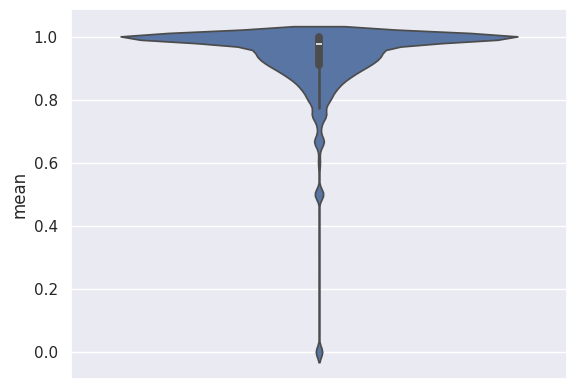

In [ ]:
decision_per_mesh = (
    pubmedqa_df[["final_decision", "context.meshes"]]
    .explode("context.meshes")
    .groupby("context.meshes")["final_decision"]
    .agg(["count", "mean"])
)

sns.violinplot(decision_per_mesh["mean"])

Apart from `final_answer`, the dataset provides `context.reasoning_required_pred` ("required" in short) and `context.reasoning_free_pred` ("free"). The collection procedure involved providing two different domain experts abstracts and questions to decide on their truthfulness; the expert to whom the abstract conclusion (`long_answer`) was _not_ provided produced "required", and the one to whom it was, "free".

We may then ask ourselves how aligned the predictions between experts is in general.

We see there is a strong tendency for agreement, with the vast majority of samples resting in the main diagonal of the matrix

<Axes: xlabel='context.reasoning_free_pred', ylabel='context.reasoning_required_pred'>

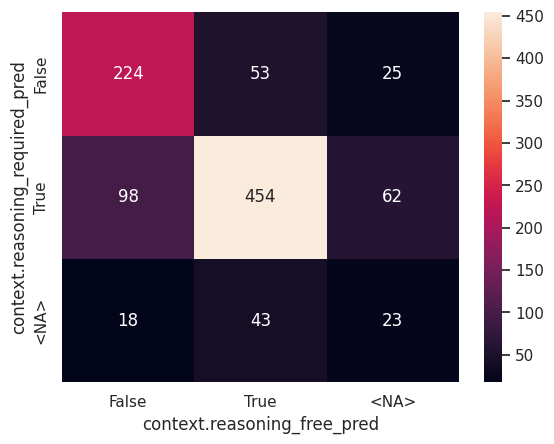

In [ ]:
sns.heatmap(
    labeled_df[["context.reasoning_required_pred", "context.reasoning_free_pred"]]
    .value_counts(dropna=False)
    .reset_index()
    .pivot_table(
        values="count",
        index="context.reasoning_required_pred",
        columns="context.reasoning_free_pred",
        dropna=False,
    )
    .astype("int"),
    annot=True,
    fmt="d",
)

Abstract sections -- stored in `context.labels` -- are in line with usual ones for the scientific literature (Background, Objective Methods and Results)

<Axes: ylabel='context.labels'>

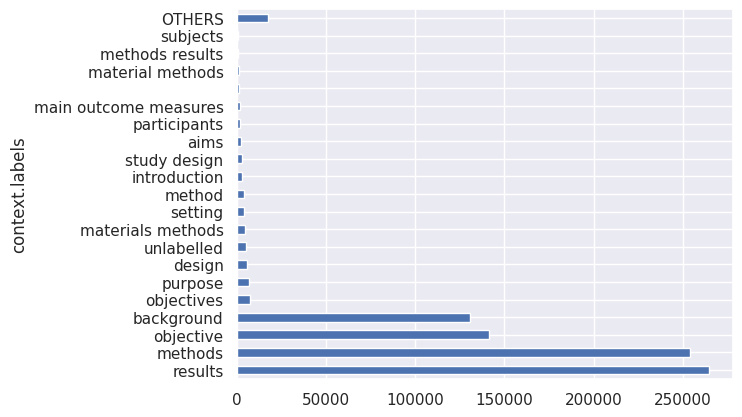

In [ ]:
context_labels = pubmedqa_df["context.labels"].explode().map(normalise_full_text)
plot_top_n_count(context_labels)

<Axes: ylabel='context.labels'>

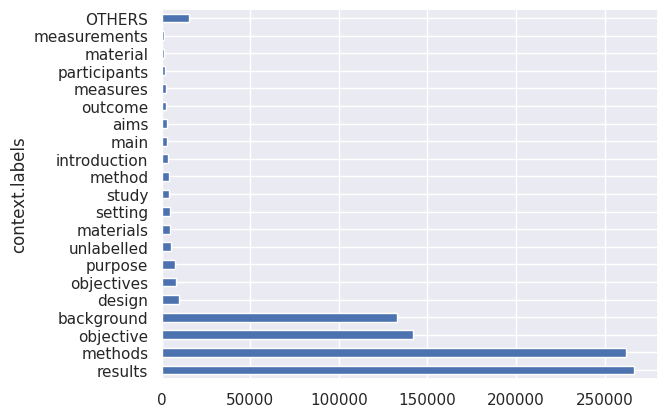

In [ ]:
plot_top_n_count(context_labels.str.split(" ").explode())

Term frequencies indicate abstracts mostly describe medical interventions on humans

<Axes: ylabel='full_text'>

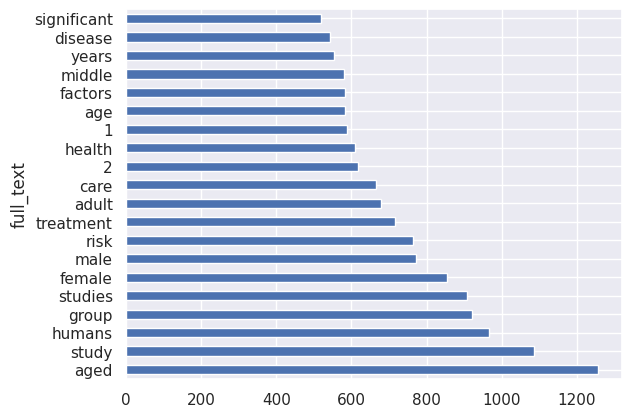

In [ ]:
plot_top_n_count(
    normalised_string_df["full_text"].str.split(" ").explode(),
    plot_others=False,
)

MeSHes are very little concentrated, suggesting they might be too unique to provide relevant information

<Axes: ylabel='context.meshes'>

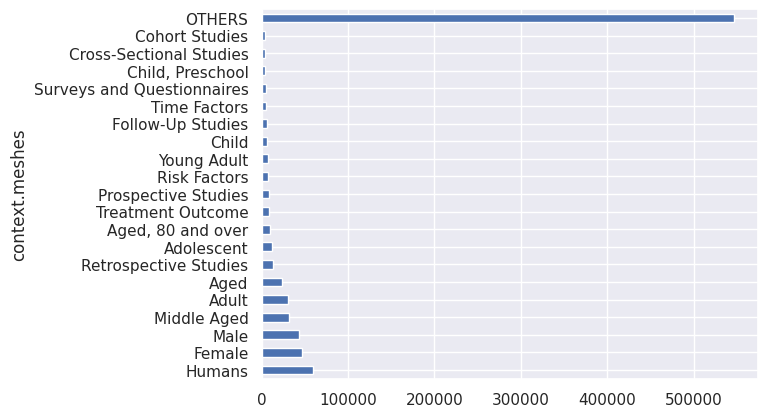

In [ ]:
plot_top_n_count(df["context.meshes"].explode())

We extract p-values from full_text and plot the most frequent ones

One interesting manually-extracted feature would be floating point values associated with p-values in the abstracts. We see that reporting of statistically significant results is predominant.

<Axes: ylabel='full_text'>

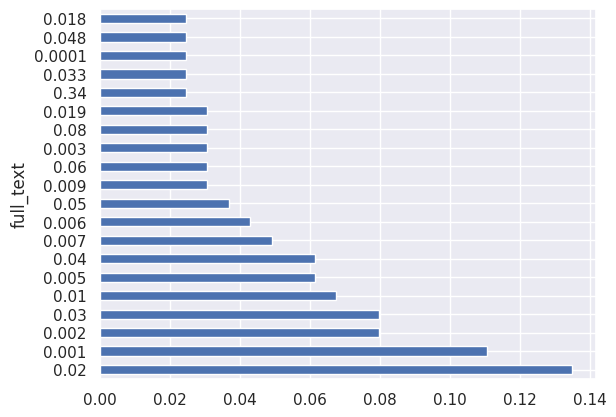

In [ ]:
p_values = labeled_df["full_text"].str.findall(r"p\s*=?\s*(\d+\.\d+)").explode().dropna()
plot_top_n_count(p_values, normalise=True, plot_others=False)

We don't indent on exploring this feature further however since our objective is to explore deep, end-to-end classification solutions that do not require manual feature engineering.

### Embeddings and clustering

In this section we compute embeddings through different models and use them in order to cluster the documents. Some of these will be used during the classification portion of the notebook as well.

#### Textual features

Bag-of-Words (BoW) representation

In [ ]:
bow_vectorizer = CountVectorizer()
bow_vectorizer.fit(normalised_string_df["full_text"])
bow_embeddings: dict[str, csr_matrix] = {
    column: bow_vectorizer.transform(normalised_string_df[column])
    for column in normalised_string_df.columns
}

To simplify the analysis, we merge similarities from different textual embeddings into a single `DataFrame`. For each one, we compute the dot product similarity between the embeddings of a question and of its context, and the average similarity between the embedding of a question and of all other contexts except for its own.

We denote the former "self-similarity" and the latter, "cross-similarity".

In [ ]:
question_context_self_similarity, question_context_cross_similarity = (
    compute_embedding_similarities(
        bow_embeddings["question"], bow_embeddings["context.full_context"]
    )
)
similarity_df = labeled_df.copy()
similarity_df["bow_self_similarity"] = question_context_self_similarity
similarity_df["bow_cross_similarity"] = question_context_cross_similarity

Term Frequency Inverse Document Frequency (TF-IDF)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(normalised_string_df["full_text"])
tfidf_embeddings: dict[str, csr_matrix] = {
    column: tfidf_vectorizer.transform(normalised_string_df[column])
    for column in normalised_string_df.columns
}

In [ ]:
for name, similarity in zip(
    ("self", "cross"),
    compute_embedding_similarities(
        tfidf_embeddings["question"], tfidf_embeddings["context.full_context"]
    ),
):
    similarity_df[f"tfidf_{name}_similarity"] = similarity

In [ ]:
similarity_df.filter(like="similarity").columns.to_list()

['bow_self_similarity',
 'bow_cross_similarity',
 'tfidf_self_similarity',
 'tfidf_cross_similarity']

The similarity distribution shows self-similarity is much greater than cross similarity for both BoW and TF-IDF (notice the different scales in the y-axis). It also shows no particular distinction between either self- or cross-similarity based on the target, suggesting a naive approach based on non-semantic textual features will not suffice to achieve high performance in Q&A.

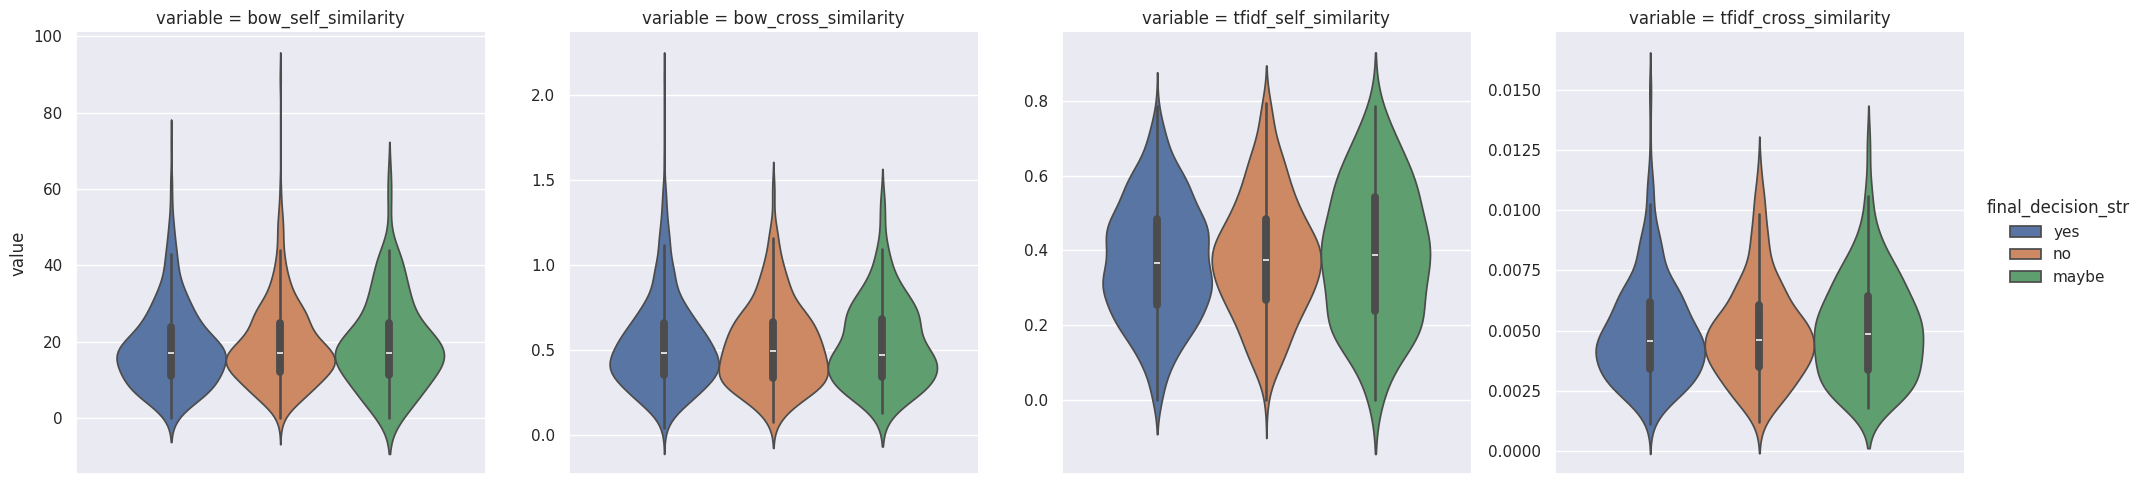

In [ ]:
similarity_sns = similarity_df[
    [*similarity_df.filter(like="similarity").columns.to_list(), "final_decision_str"]
].melt("final_decision_str")
sns.catplot(
    similarity_sns,
    col="variable",
    y="value",
    hue="final_decision_str",
    kind="violin",
    sharey=False,
)

Projecting the embeddings into a low-dimensional space with SVD followed by t-SNE shows no discernable pattern with respect to the target.

<Axes: xlabel='tsne_0', ylabel='tsne_1'>

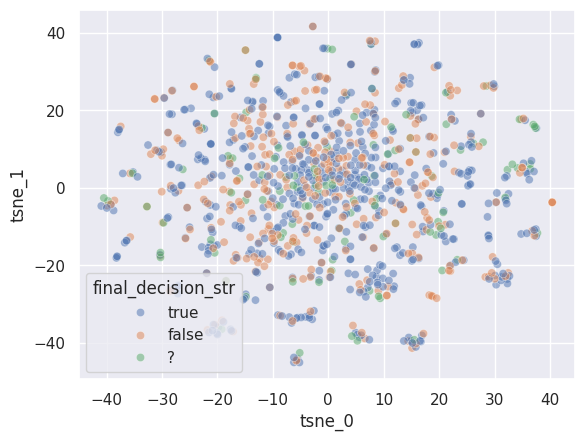

In [ ]:
tfidf_tsne_df = svd_tsne(tfidf_embeddings["full_text"])
tfidf_tsne_df.index = labeled_df.index
tfidf_tsne_df["final_decision_str"] = labeled_df["final_decision_str"]
sns.scatterplot(
    tfidf_tsne_df,
    x="tsne_0",
    y="tsne_1",
    hue="final_decision_str",
    alpha=0.5,
)

#### Sent2Vec


##### Embedding analysis

Sent2Vec must be installed from its GitHub repository, and consumes more CPU memory than is available in cloud runners such as Kaggle or Google Colab, which makes its execution in a notebook cumbersome. Therefore, we load embeddings computed using a dedicated Python script ([`compute_sent2vec_embeddings.py`](compute_sent2vec_embeddings.py))

We once again focus on the labelled dataset for computational efficiency reasons.

In [ ]:
SENTENCE_EMBEDDINGS_PATH = Path("embeddings") / "sentence" / "labeled"

In [ ]:
sentence_embeddings: dict[str, dict[str, np.ndarray]] = {}
for path in SENTENCE_EMBEDDINGS_PATH.iterdir():
    if not path.is_file():
        continue
    embeddings_archive: NpzFile = np.load(path)
    normalised_embeddings_dict = {
        key: value / np.linalg.norm(value, axis=1).reshape((-1, 1))
        for key, value in embeddings_archive.items()
    }
    sentence_embeddings[path.stem] = normalised_embeddings_dict
sentence_embeddings.keys()

dict_keys(['BioSentVec_PubMed_MIMICIII-bigram_d700', 'wiki_bigrams'])

In [ ]:
example_sentence_embeddings = sentence_embeddings[
    "BioSentVec_PubMed_MIMICIII-bigram_d700"
]
example_sentence_embeddings.keys()

dict_keys(['question', 'long_answer', 'context.full_context', 'context.full_meshes', 'full_text', 'no_reasoning'])

Since we normalised the embeddings when loading them, we expect them to have norma around 1, with slight variations due to numerical precision.

In [ ]:
np.unique(
    np.linalg.norm(
        example_sentence_embeddings["full_text"],
        axis=1,
    ),
    return_counts=True,
)

(array([0.9999999 , 0.99999994, 1.        , 1.0000001 ], dtype=float32),
 array([  2, 300, 689,   9]))

Analysing average norm of the distance between embeddings containing and excluding the conclusion, we see that its inclusion did not significantly impact embedding similarity.

Text(0.5, 1.0, 'Distance distribution between full_text and no_reasoning')

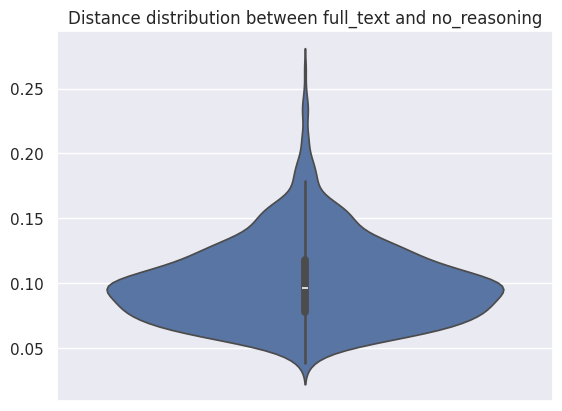

In [ ]:
example_reasoning_difference = (
    example_sentence_embeddings["full_text"]
    - example_sentence_embeddings["no_reasoning"]
)
ax = sns.violinplot(
    np.linalg.norm(
        example_reasoning_difference,
        axis=1,
    )
)
ax.set_title("Distance distribution between full_text and no_reasoning")

PCA suggests the dataset does not have any particularly important direction in the embedding space, as the lack of a knee in the explained variance cumulative sum illustrates.

[Text(0.5, 1.0, 'Cumulative explained variance for full_text'),
 Text(0.5, 0, 'Principal component'),
 Text(0, 0.5, 'Explained variance')]

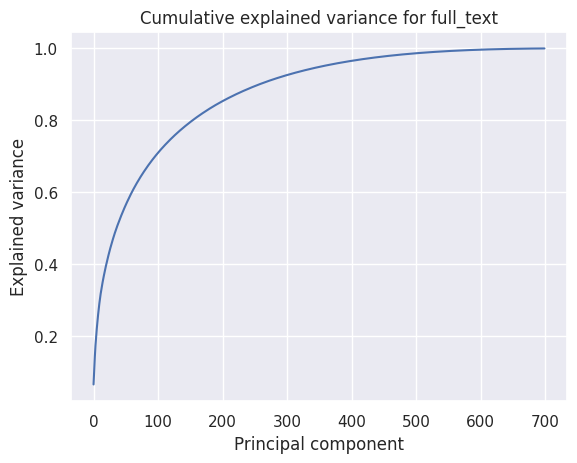

In [ ]:
ax = sns.lineplot(
    np.cumsum(
        PCA().fit(example_sentence_embeddings["full_text"]).explained_variance_ratio_
    )
)
ax.set(
    title="Cumulative explained variance for full_text",
    xlabel="Principal component",
    ylabel="Explained variance",
)

The same follows for the difference between embeddings with and without conclusion.

[Text(0.5, 1.0, 'Cumulative explained variance for difference between full_text and no_reasoning'),
 Text(0.5, 0, 'Principal component'),
 Text(0, 0.5, 'Explained variance')]

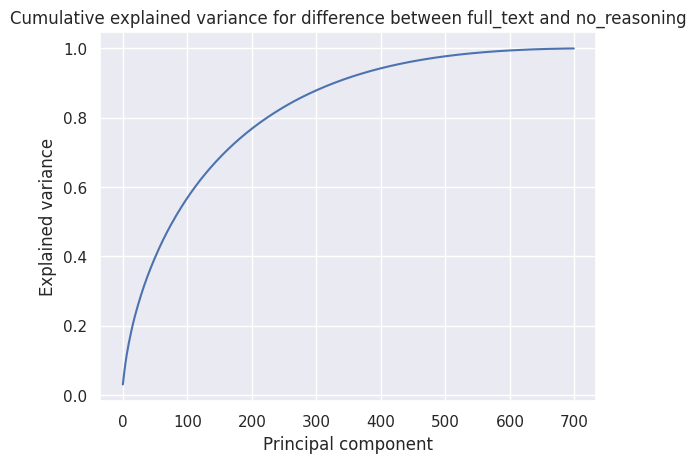

In [ ]:
ax = sns.lineplot(
    np.cumsum(PCA().fit(example_reasoning_difference).explained_variance_ratio_)
)
ax.set(
    title="Cumulative explained variance for difference between full_text and no_reasoning",
    xlabel="Principal component",
    ylabel="Explained variance",
)

##### Clustering

In [ ]:
example_embeddings_to_cluster = example_sentence_embeddings["full_text"]

Hierarchical clustering lets us inspect generated clusters to choose an adequate distance cutoff

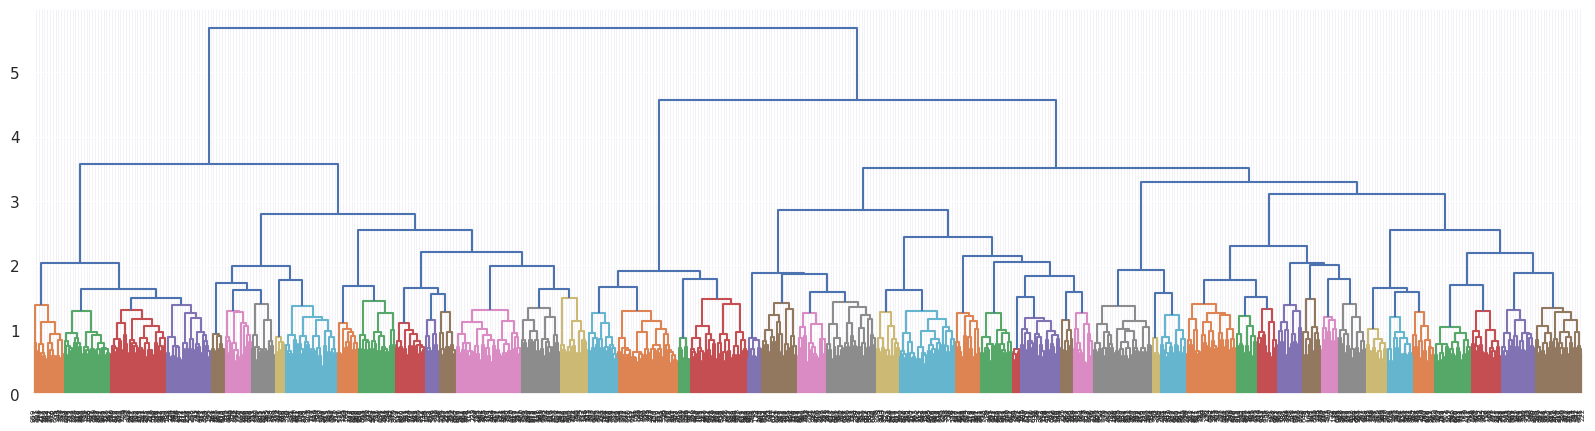

In [ ]:
example_hierarchical_clustering = AgglomerativeClustering(
    compute_distances=True,
)
fig, ax = plt.subplots(figsize=(20, 5))
plot_dendrogram(
    example_hierarchical_clustering,
    color_threshold=1.5,
    ax=ax,
)

We can identify an elbow in the distance a distance of approximately 1.5. This can give us an indication on a cutoff point for the number of clusters.

Text(0, 0.5, 'Distance')

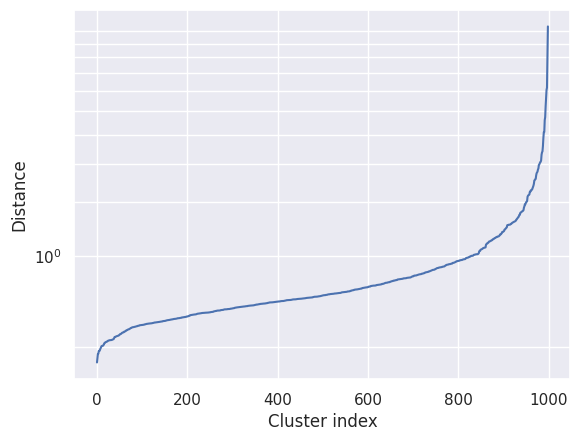

In [ ]:
ax = plt.subplot()
ax.set_yscale("log")
sns.lineplot(example_hierarchical_clustering.distances_, ax=ax)
ax.set_yticks(np.arange(0.5, 6.0, 0.5))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Distance")

In [ ]:
def compute_intermediate_clustering(
    model: AgglomerativeClustering,
    max_distance: float,
) -> tuple[int, dict[int, list[int]]]:
    n_samples = len(model.labels_)
    clusters = {i: [i] for i in range(n_samples)}
    for i, (merge, distance) in enumerate(
        zip(
            model.children_,
            model.distances_,
        )
    ):
        if distance > max_distance:
            break
        clusters[n_samples + i] = clusters[merge[0]] + clusters[merge[1]]
        clusters.pop(merge[0])
        clusters.pop(merge[1])
    return i, clusters

In [ ]:
last_merge, example_intermediate_clusters = compute_intermediate_clustering(
    example_hierarchical_clustering,
    max_distance=1.5,
)
print(len(example_intermediate_clusters))

50


At the selected cutoff, we see much greater structure when compared with the low-dimensionality representation of the textual features alone

<Axes: xlabel='tsne_0', ylabel='tsne_1'>

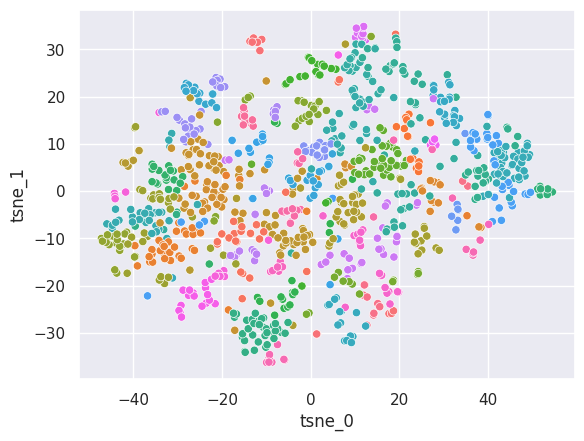

In [ ]:
example_intermediate_cluster_df = (
    pd.DataFrame(
        [
            (node, cluster_key)
            for cluster_key, cluster in example_intermediate_clusters.items()
            for node in cluster
        ],
        columns=["node", "cluster_key"],
        dtype="int",
    )
    .set_index("node")
    .sort_index()
    .astype("string")
)

example_cluster_df = (
    normalised_string_df.reset_index()
    .join(example_intermediate_cluster_df)
    .join(svd_tsne(example_embeddings_to_cluster))
)

sns.scatterplot(
    example_cluster_df,
    x="tsne_0",
    y="tsne_1",
    hue="cluster_key",
    legend=False,
)

Here, we study how the words are distributed in each cluster and compare that to the distribution in the corpus. This helps in highlighting the shared characteristics of members of the cluster not shared by the rest of the dataset on average.

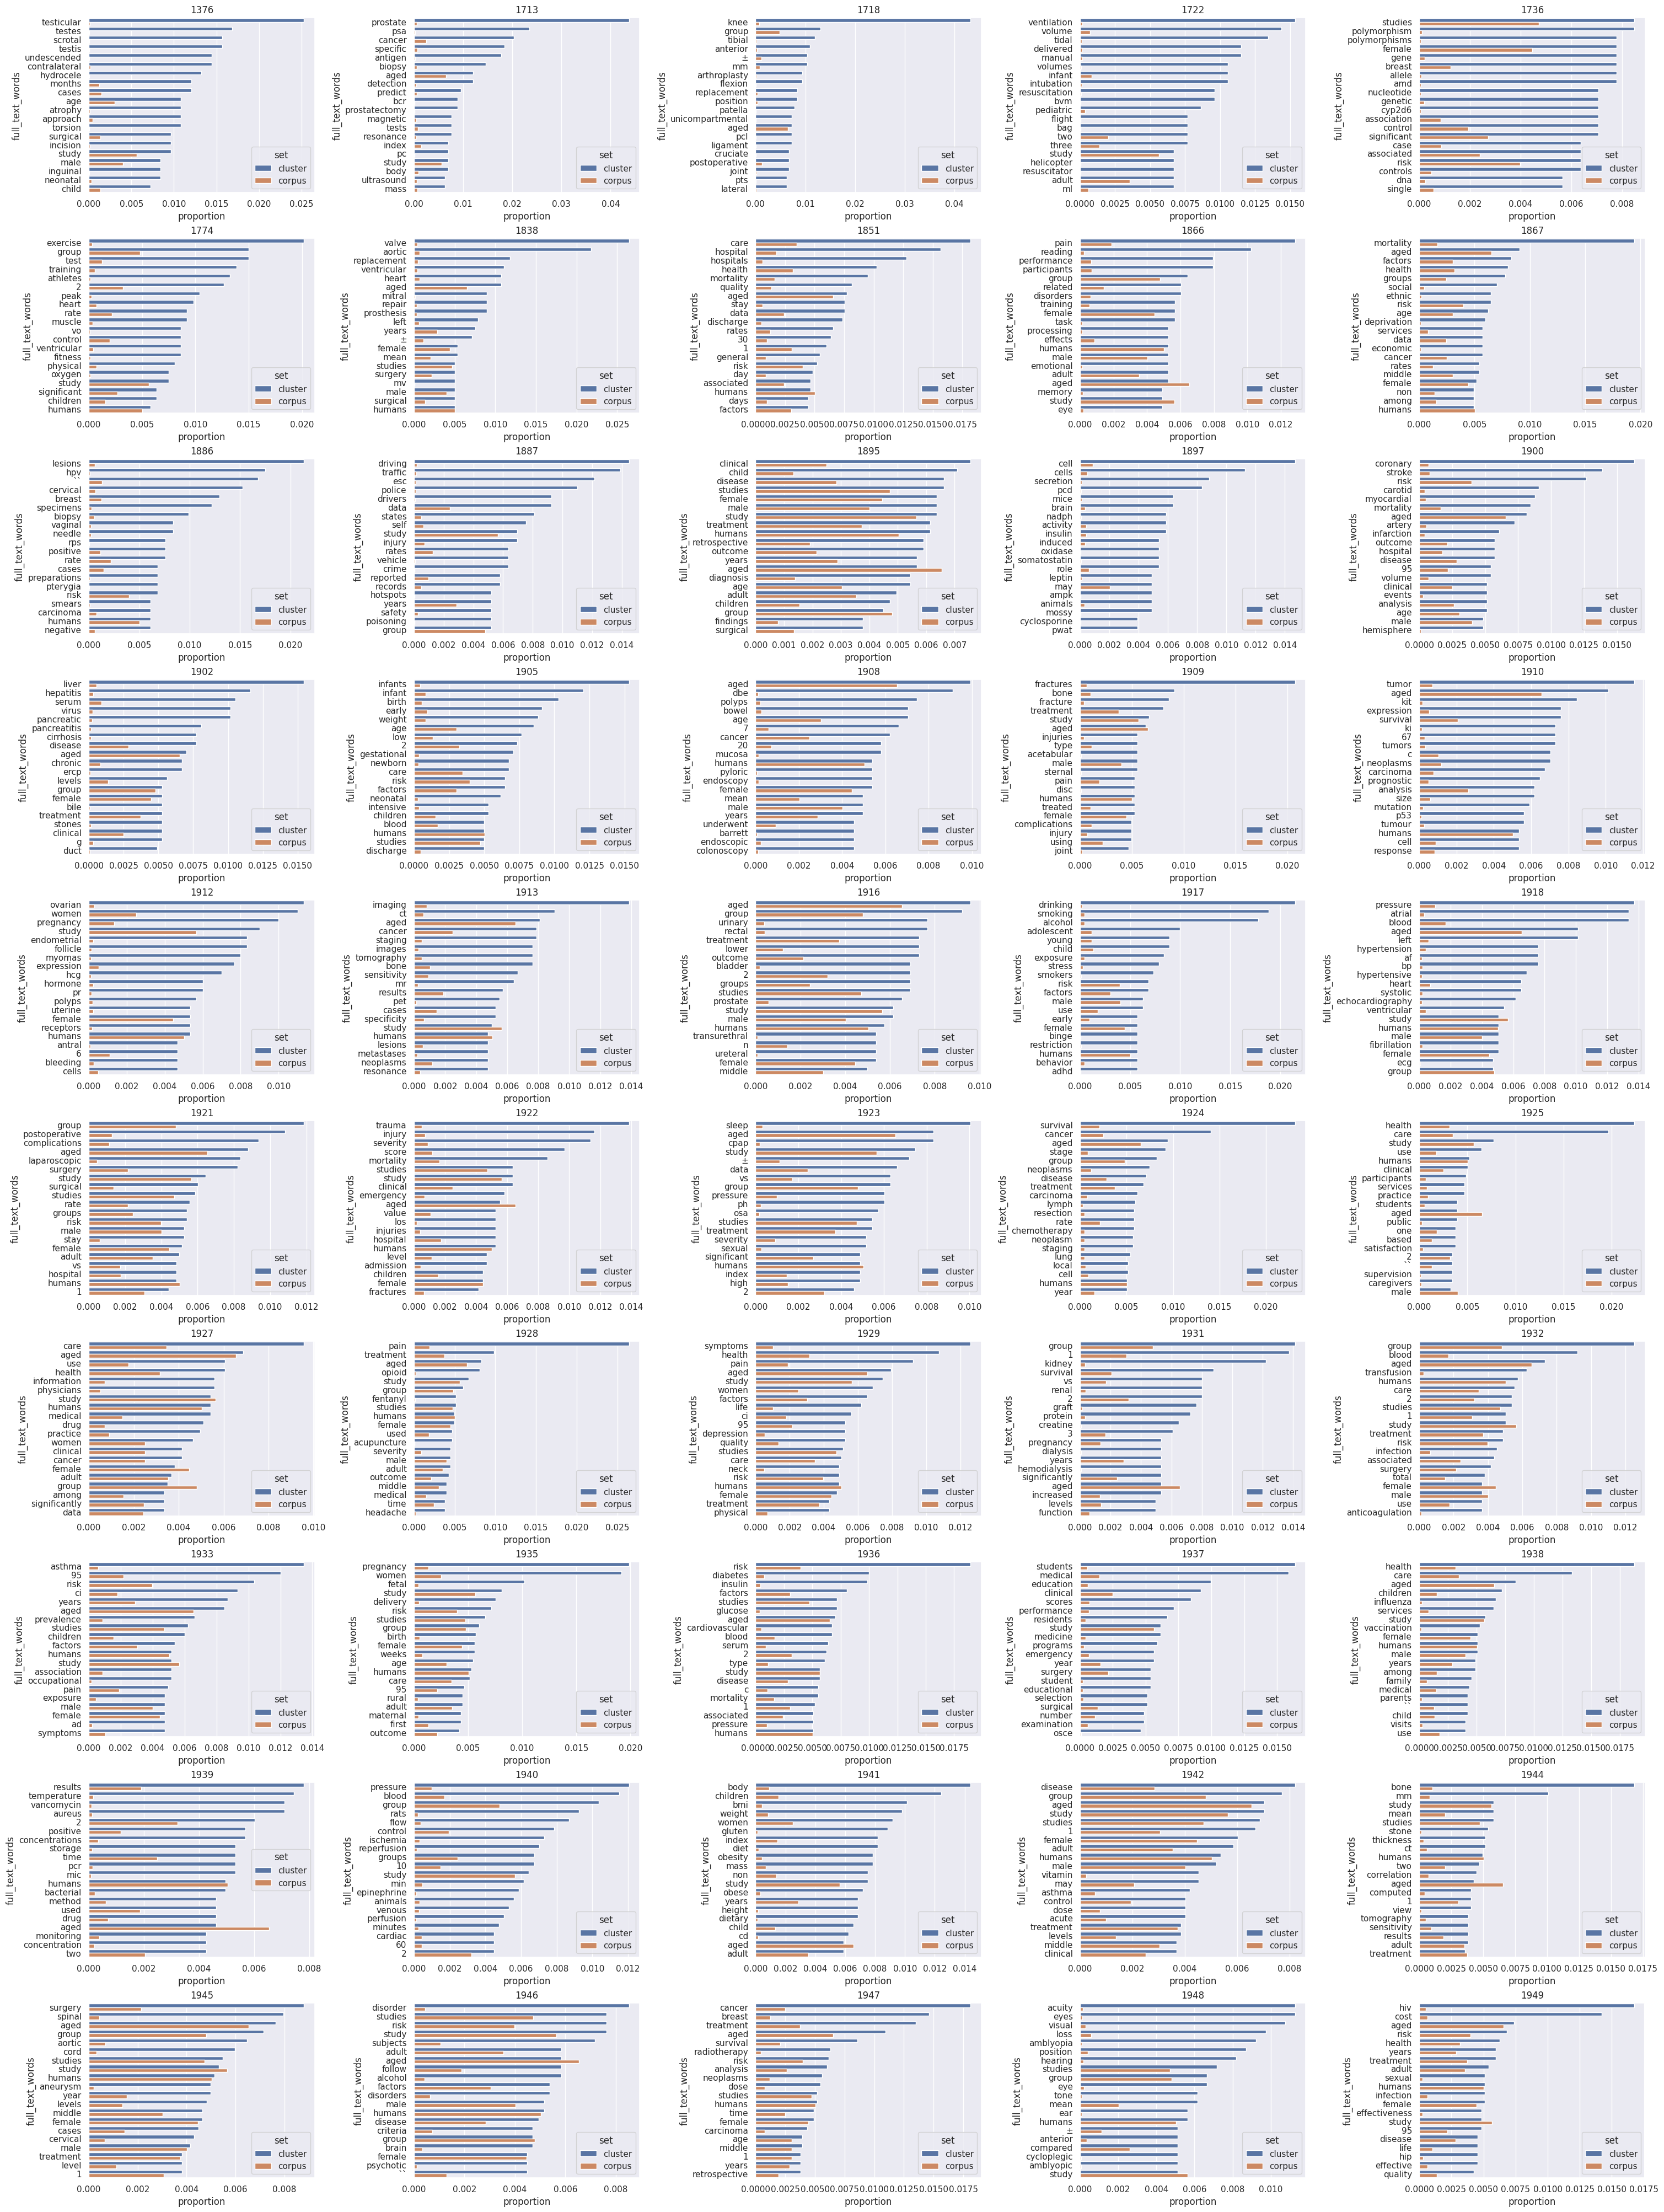

In [ ]:
NCOLS = 5
TOP_N = 20

nrows = int(np.ceil(len(example_intermediate_clusters) / NCOLS))
fig, axes = plt.subplots(
    ncols=NCOLS,
    nrows=nrows,
    sharex=False,
    sharey=False,
    figsize=(NCOLS * 6, nrows * 4),
    layout="constrained",
)
corpus_count = (
    normalised_string_df["full_text"]
    .str.split(" ")
    .explode()
    .value_counts(normalize=True)
)

example_cluster_df["full_text_words"] = example_cluster_df["full_text"].str.split(" ")
word_count_groupby = (
    example_cluster_df[["cluster_key", "full_text_words"]]
    .explode("full_text_words")
    .groupby("cluster_key")
)
for ax, (cluster_key, words_df) in zip(axes.ravel(), word_count_groupby):
    plot_cluster_corpus_word_counts(words_df, corpus_count, ax=ax)
    ax.set_title(cluster_key)

Indeed, for example it is very clear that the first cluster is about male-specific attributes and illnesses.

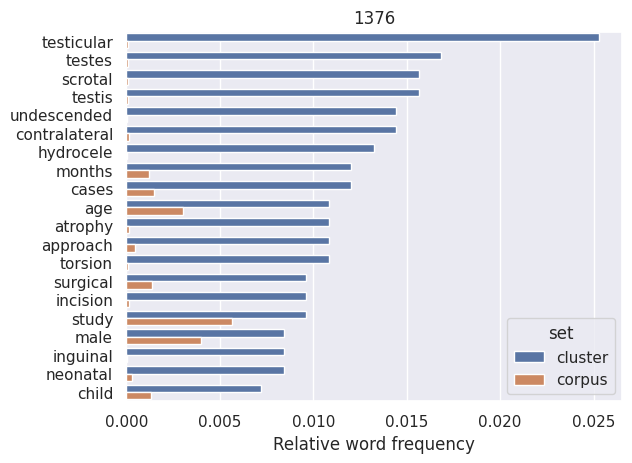

In [ ]:
CLUSTER_INDEX_TO_FOCUS = 0

focus_fig, focus_ax = plt.subplots()
for i, (ax, (cluster_key, words_df)) in enumerate(zip(axes.ravel(), word_count_groupby)):
    if i != CLUSTER_INDEX_TO_FOCUS:
        continue
    plot_cluster_corpus_word_counts(words_df, corpus_count, ax=focus_ax)
    focus_ax.set(
        title=cluster_key,
        ylabel="",
        xlabel="Relative word frequency",
    )

#### Sentence Transformer and UMAP

We load a pretrained Sentence Transformer built on BioBERT

In [ ]:
# Load pretrained biomedical model

model = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")

We try clustering with the KMeans algorithm. We choose 10 clusters that are based off the enbeddings of the questions generated from the pretrained sentence transformer.

In [ ]:
# we start with the labeled dataset
questions = labeled_df["train"]["question"]

# Get sentence embeddings
embeddings = model.encode(questions, show_progress_bar=True)

# Choose number of clusters
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Create a DataFrame for analysis
df_clustered = pd.DataFrame({"question": questions, "cluster": clusters})

In [ ]:
# Preview questions in each cluster
for i in range(num_clusters):
    print(f"\n--- Cluster {i} ---")
    sample_questions = df_clustered[df_clustered['cluster'] == i]['question'].head(5)
    for q in sample_questions:
        print(f"- {q}")



--- Cluster 0 ---
- Is aneurysm repair justified for the patients aged 80 or older after aneurysmal subarachnoid hemorrhage?
- Is it appropriate to implant kidneys from elderly donors in young recipients?
- Do instrumental activities of daily living predict dementia at 1- and 2-year follow-up?
- Is a patient's self-reported health-related quality of life a prognostic factor for survival in non-small-cell lung cancer patients?
- Do all ethnic groups in New Zealand exhibit socio-economic mortality gradients?

--- Cluster 1 ---
- Do mitochondria play a role in remodelling lace plant leaves during programmed cell death?
- 30-Day and 1-year mortality in emergency general surgery laparotomies: an area of concern and need for improvement?
- Therapeutic anticoagulation in the trauma patient: is it safe?
- Patient-Controlled Therapy of Breathlessness in Palliative Care: A New Therapeutic Concept for Opioid Administration?
- Israeli hospital preparedness for terrorism-related multiple casualty 

We can see that for most of the clusters we can clearly identify a central topic of interest. For example, the first cluster focuses on elderly patients, the second on death and mortality, the third on questions that ask if a factor is relevant to a topic of interest and so on.

Now, we use t-distributed Stochastic Neighbor Embedding to reduce our embeddings dimensionality and plot them in a 2D space, trying to keep similar points close together, in order to visualize the clusters distribution.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


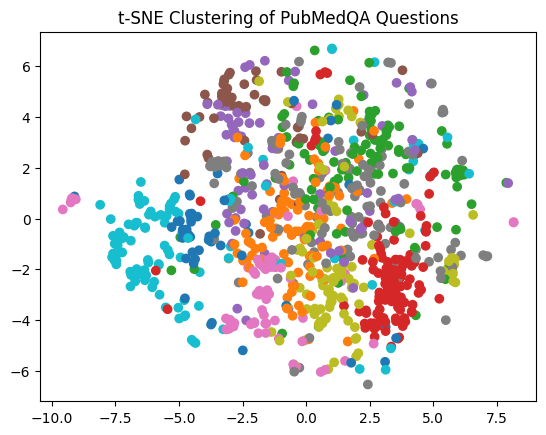

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

plt.scatter(tsne_results[:,0], tsne_results[:,1], c=clusters, cmap='tab10')
plt.title("t-SNE Clustering of PubMedQA Questions")
plt.show()




The clusters are still mixed in the space but they appear more concentrated in some areas.

Now, we use Uniform Manifold Approximation and Projection to visualize again the clusters. The advantages of this approach are that the global structure is better preserved and it is less sensitive to parameter tuning.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


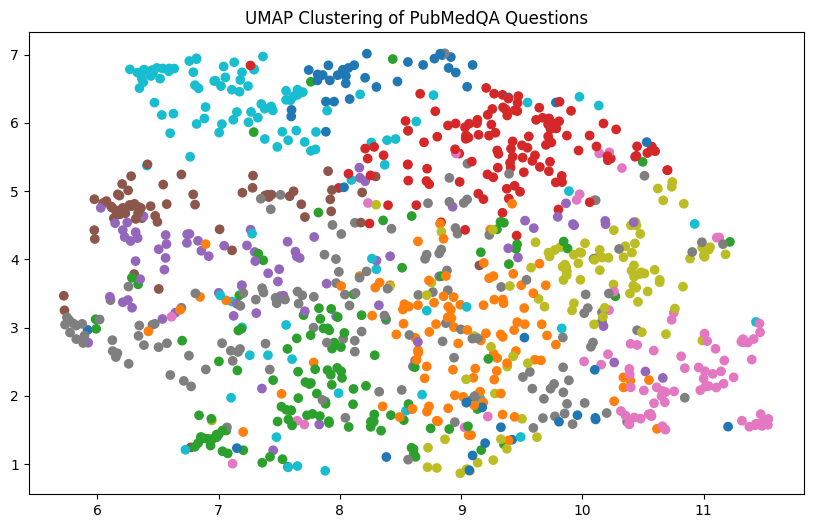

In [ ]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=clusters, cmap='tab10')
plt.title("UMAP Clustering of PubMedQA Questions")
plt.show()




We now apply TF-IDF to identify the most representative words in each cluster, helping us better understand their composition and underlying themes.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Build a custom stopword list
custom_stopwords = set(stopwords.words('english'))
custom_stopwords.update([
    'does', 'do', 'did', 'is', 'are', 'was', 'were', 'can', 'could', 'should',
    'would', 'what', 'when', 'where', 'why', 'how', 'will', 'shall', 'may',
    'also', 'use', 'used', 'using'
])

# Get top words per cluster using custom stopwords
def get_top_terms_per_cluster(df, num_terms=5):
    # Convert custom_stopwords to a list
    custom_stopwords_list = list(custom_stopwords)
    vectorizer = TfidfVectorizer(stop_words=custom_stopwords_list) # Pass the list here
    tfidf_matrix = vectorizer.fit_transform(df['question'])
    feature_names = vectorizer.get_feature_names_out()

    top_terms = {}
    for cluster_id in sorted(df['cluster'].unique()):
        idxs = df[df['cluster'] == cluster_id].index
        cluster_matrix = tfidf_matrix[idxs]
        avg_tfidf = np.asarray(cluster_matrix.mean(axis=0)).flatten()
        top_indices = avg_tfidf.argsort()[::-1][:num_terms]
        terms = [feature_names[i] for i in top_indices]
        top_terms[cluster_id] = terms
    return top_terms

# Run the analysis
top_words = get_top_terms_per_cluster(df_clustered)
for cid, words in top_words.items():
    print(f"Cluster {cid}: {', '.join(words)}")

Cluster 0: life, patients, elderly, quality, older
Cluster 1: patients, acute, mortality, surgery, injury
Cluster 2: risk, patients, diabetes, disease, type
Cluster 3: cancer, breast, carcinoma, cell, chemotherapy
Cluster 4: children, pediatric, infants, young, obesity
Cluster 5: pregnancy, women, delivery, risk, fetal
Cluster 6: fractures, knee, pain, spinal, cervical
Cluster 7: predict, disease, symptoms, syndrome, exist
Cluster 8: laparoscopic, surgery, safe, repair, affect
Cluster 9: care, medical, practice, patient, health


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The clusters have clearly defined themes. The first one is about elder care, the second one is about injuries and pain, the fourth one is cancer related, the fifth one focuses on infancy and so on.

Now we repeat the same operation but we will now use the full dataset (the labeled, unlabeled and the artificial combined)

In [ ]:
def extract_df(ds, source_label, sample_size=None, include_decision=False):
    data = ds["train"]
    if sample_size:
        indices = sample(range(len(data)), sample_size)
        data = data.select(indices)

    # Extract basic fields
    df = pd.DataFrame(
        {
            "question": data["question"],
            "long_answer": data["long_answer"],
            "context": [" ".join(c["contexts"]) for c in data["context"]],
            "source": source_label,
        }
    )

    # Add short answer (final_decision) if available
    if include_decision and "final_decision" in data.features:
        df["final_decision"] = data["final_decision"]
    else:
        df["final_decision"] = None

    return df


In [ ]:
from datasets import load_dataset

ds_artificial = load_dataset("qiaojin/PubMedQA", "pqa_artificial")
ds_labeled= load_dataset("qiaojin/PubMedQA", "pqa_labeled")
ds_unlabeled= load_dataset("qiaojin/PubMedQA", "pqa_unlabeled")

df_labeled = extract_df(ds_labeled, "labeled", include_decision=True)
df_unlabeled = extract_df(ds_unlabeled, "unlabeled", sample_size=2000)
df_artificial = extract_df(ds_artificial, "artificial", sample_size=1000)

df_combined = pd.concat([df_labeled, df_unlabeled, df_artificial], ignore_index=True)
df_clustered = df_combined.copy()

In [ ]:
texts_to_embed = df_combined["question"].tolist()
embeddings1 = model.encode(
    texts_to_embed, show_progress_bar=True
)  # we use the sentence transformer to encode the embeddings

We use the KMeans algorithm to define 10 clusters from the merged dataset and we inspect them as before.

In [ ]:
# Choose number of clusters
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings1)

df_clustered = df_combined.copy()
df_clustered["cluster"] = clusters

In [ ]:
# Preview questions in each cluster
for i in range(num_clusters):
    print(f"\n--- Cluster {i} ---")
    sample_questions = df_clustered[df_clustered['cluster'] == i]['question'].head(5)
    for q in sample_questions:
        print(f"- {q}")


--- Cluster 0 ---
- Is adjustment for reporting heterogeneity necessary in sleep disorders?
- Are reports of mechanical dysfunction in chronic oro-facial pain related to somatisation?
- Major depression and alcohol use disorder in adolescence: Does comorbidity lead to poorer outcomes of depression?
- Injury and poisoning mortality among young men--are there any common factors amenable to prevention?
- Aripiprazole: a new risk factor for pathological gambling?

--- Cluster 1 ---
- Implementation of epidural analgesia for labor: is the standard of effective analgesia reachable in all women?
- Continuation of pregnancy after antenatal corticosteroid administration: opportunity for rescue?
- Does the clinical presentation of a prior preterm birth predict risk in a subsequent pregnancy?
- Are women with major depression in pregnancy identifiable in population health data?
- Is perforation of the appendix a risk factor for tubal infertility and ectopic pregnancy?

--- Cluster 2 ---
- Landol

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


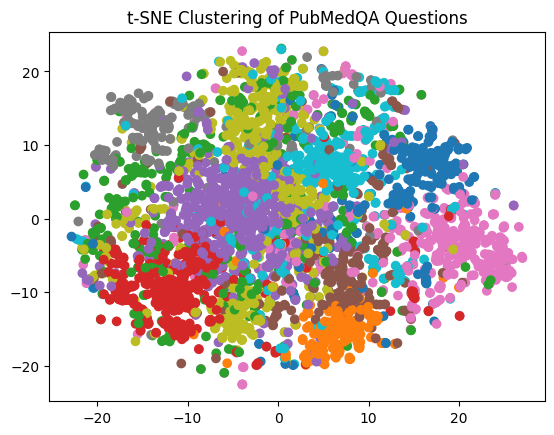

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(embeddings1)

plt.scatter(tsne_results[:,0], tsne_results[:,1], c=clusters, cmap='tab10')
plt.title("t-SNE Clustering of PubMedQA Questions")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


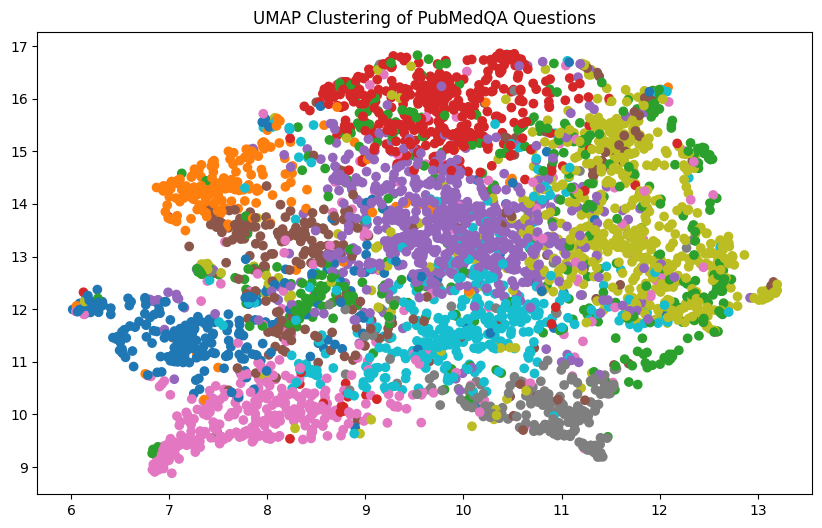

In [ ]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings1 = umap_model.fit_transform(embeddings1)

plt.figure(figsize=(10, 6))
plt.scatter(umap_embeddings1[:,0], umap_embeddings1[:,1], c=clusters, cmap='tab10')
plt.title("UMAP Clustering of PubMedQA Questions")
plt.show()


In [ ]:
# Get top words per cluster using custom stopwords
def get_top_terms_per_cluster(df, num_terms=5):
    # Convert custom_stopwords to a list
    custom_stopwords_list = list(custom_stopwords)
    vectorizer = TfidfVectorizer(stop_words=custom_stopwords_list) # Pass the list here
    tfidf_matrix = vectorizer.fit_transform(df['question'])
    feature_names = vectorizer.get_feature_names_out()

    top_terms = {}
    for cluster_id in sorted(df['cluster'].unique()):
        idxs = df[df['cluster'] == cluster_id].index
        cluster_matrix = tfidf_matrix[idxs]
        avg_tfidf = np.asarray(cluster_matrix.mean(axis=0)).flatten()
        top_indices = avg_tfidf.argsort()[::-1][:num_terms]
        terms = [feature_names[i] for i in top_indices]
        top_terms[cluster_id] = terms
    return top_terms

# Run the analysis
top_words = get_top_terms_per_cluster(df_clustered)
for cid, words in top_words.items():
    print(f"Cluster {cid}: {', '.join(words)}")

Cluster 0: depression, disorder, smoking, patients, treatment
Cluster 1: pregnancy, women, risk, delivery, fetal
Cluster 2: imaging, tomography, computed, patients, predict
Cluster 3: cancer, carcinoma, breast, patients, prostate
Cluster 4: cells, cell, induced, human, protein
Cluster 5: children, pediatric, infants, childhood, age
Cluster 6: care, health, patients, medical, practice
Cluster 7: knee, fractures, pain, hip, osteoarthritis
Cluster 8: patients, surgery, laparoscopic, aortic, safe
Cluster 9: associated, diabetes, risk, disease, patients


Even if the order of the clusters is different, we find similar clusters to the ones we saw before. For example, cluster 3 and cluster 5 top words are the same as two of the clusters in the previous analysis.

### Keyword search

In this subsection, we focus on indexing the documents in the dataset and performing keyword search over them through different techniques in order to compare the performances we obtain.

##### TF-IDF tokenizer
We start by performing keyword search with TF-IDF over the labeled dataset.

In [ ]:
# Convert nested fields to strings
def extract_text(entry):
    if isinstance(entry, dict):
        return " ".join(str(v) for v in entry.values())
    return str(entry)


df_labeled = labeled_df.copy()
df_artificial = artificial_df.copy()
df_unlabeled = unlabeled_df.copy()


df_labeled["question"] = df_labeled["question"].apply(extract_text)
df_labeled["context"] = df_labeled["context"].apply(extract_text)
df_labeled["long_answer"] = df_labeled["long_answer"].apply(extract_text)

# Combine relevant text fields for indexing
df_labeled["combined_text"] = (
    df_labeled["question"]
    + " "
    + df_labeled["context"]
    + " "
    + df_labeled["long_answer"]
)

In [ ]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(labeled_df["combined_text"])

Here, we base our search on cosine similarity.

In [ ]:
# Define a keyword search function
def keyword_search_tfidf(query, top_n=5):
    query_vec = vectorizer.transform([query])
    cosine_sim = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_indices = cosine_sim.argsort()[-top_n:][::-1]
    results = df_labeled.iloc[top_indices][["question", "context", "long_answer"]]

    # Get set of important query words
    query_terms = set(query.lower().split())
    query_tfidf = vectorizer.transform([query])
    feature_names = vectorizer.get_feature_names_out()

    # Display results in a readable format with highlighted relevant words
    for rank, idx in enumerate(top_indices):
        row = df_labeled.iloc[idx]
        similarity_score = cosine_sim[idx]

        def highlight(text):
            return " ".join(
                [
                    f"**{word}**" if word.lower() in query_terms else word
                    for word in text.split()
                ]
            )

        question = highlight(row["question"])
        context = highlight(row["context"])
        answer = highlight(row["long_answer"])

        display(
            Markdown(
                f"### Result {rank + 1} (Similarity: {similarity_score:.4f})\n"
                + f"**Question:** {question}\n\n"
                + f"**Context:** {context}\n\n"
                + f"**Answer:** {answer}\n\n---"
            )
        )

In [ ]:
display(Markdown("##TF-IDF Tokenizer search"))
keyword_search_tfidf("Heart attack")

We can see that the similarity score is not very high and that we are getting results coherent with just one of the two words, the first result being related to heart.

##### Doc2Vec
Now, we try seeing how Doc2Vec performs over the artificial one.

In [ ]:
def extract_text(entry):
    if isinstance(entry, dict):
        return " ".join(str(v) for v in entry.values())
    return str(entry)


df_artificial["question"] = df_artificial["question"].apply(extract_text)
df_artificial["context"] = df_artificial["context"].apply(extract_text)
df_artificial["long_answer"] = df_artificial["long_answer"].apply(extract_text)

# Combine relevant text fields for indexing
df_artificial["combined_text"] = (
    df_artificial["question"]
    + " "
    + df_artificial["context"]
    + " "
    + df_artificial["long_answer"]
)

In [ ]:
# Prepare data for Doc2Vec
documents = [
    TaggedDocument(words=word_tokenize(text.lower()), tags=[str(i)])
    for i, text in enumerate(df_artificial["combined_text"])
]

# Train Doc2Vec model
model = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=40)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
model.save(str(ROOT_PATH / "doc2vec_model.model"))

In [ ]:
print(hasattr(model, "syn1neg"))  # should return True
print(hasattr(model, "dv"))  # should return True

In [ ]:
def keyword_search(query, df, model, topn=5):
    query_tokens = word_tokenize(query.lower())
    query_vector = model.infer_vector(query_tokens)
    similar_docs = model.dv.most_similar([query_vector], topn=topn)

    for rank, (doc_tag, sim_score) in enumerate(similar_docs):
        try:
            row = df.iloc[int(doc_tag)]
            display(
                Markdown(
                    f"### Result {rank + 1} (Similarity: {sim_score:.4f})\n"
                    + f"**Question:** {str(row.get('question', ''))}\n\n"
                    + f"**Context:** {str(row.get('context', ''))}\n\n"
                    + f"**Answer:** {str(row.get('long_answer', ''))}\n\n---"
                )
            )
        except Exception as e:
            print(f"Warning: could not display result {rank + 1} (tag: {doc_tag}): {e}")


keyword_search("Heart attack", df_artificial, model)

Now we are getting higher similarity results, but only one of these results is truly inherent to our keywords.

##### Word2Vec
We try again on the labeled dataset, but now we use Word2Vec.

In [ ]:
def preprocess_text(text):
    return word_tokenize(text.lower())  # we remove uppercases to reduce the vocabulary.

In [ ]:
sentences = []
for index, row in df_labeled.iterrows():
    if pd.notnull(row["question"]):
        sentences.append(preprocess_text(row["question"]))
    if pd.notnull(row["context"]):
        sentences.append(preprocess_text(row["context"]))

print(f"Total sentences processed: {len(sentences)}")

In [ ]:
# Train the Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

In [ ]:
# Cell 5: Compute sentence embedding by averaging word vectors
def get_sentence_vector(sentence):
    tokens = preprocess_text(sentence)
    vectors = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)


# Precompute embeddings for all rows
df_labeled["combined_text"] = (
    df_labeled["question"].fillna("") + " " + df_labeled["context"].fillna("")
)
df_labeled["embedding"] = df_labeled["combined_text"].apply(get_sentence_vector)

In [ ]:
def keyword_search_word2vec(query, topn=5):
    query_vec = get_sentence_vector(query)
    similarities = []
    for idx, row in df_labeled.iterrows():
        row_vec = row["embedding"]
        sim = np.dot(query_vec, row_vec) / (
            np.linalg.norm(query_vec) * np.linalg.norm(row_vec) + 1e-10
        )
        similarities.append(sim)
    df_labeled["similarity"] = similarities
    top_results = df_labeled.sort_values(by="similarity", ascending=False).head(topn)

    for rank, (idx, row) in enumerate(top_results.iterrows()):
        sim_score = row["similarity"]
        display(
            Markdown(
                f"### Result {rank + 1} (Similarity: {sim_score:.4f})\n"
                + f"**Question:** {row['question']}\n\n"
                + f"**Context:** {row['context']}\n\n"
                + f"**Answer:** {row['long_answer']}\n\n---"
            )
        )

In [ ]:
query = "heart attack"
keyword_search_word2vec(query)

We are getting very high similarity scores, but still only one result may interest us, so the results are not much better than before.

##### Question-based keyword search
Now, we try to see what we get when we index the documents only based on the questions.

In [ ]:
df_clustered = pd.DataFrame(
    {
        "question": ds_labeled["train"]["question"],
        "long_answer": ds_labeled["train"]["long_answer"],
        "context": ds_labeled["train"]["context"],
        "final_decision": ds_labeled["train"]["final_decision"],
    }
)

In [ ]:
# If you're indexing by question meaning
model = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")
embeddings = model.encode(df_clustered["question"].tolist(), show_progress_bar=True)
df_clustered["cluster"] = KMeans(n_clusters=10, random_state=42).fit_predict(embeddings)

# Rebuild the TF-IDF matrix to match the new DataFrame
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(df_clustered["question"])

In [ ]:
def search_questions(query, top_k=5, round_decimals=4):
    query_vector = vectorizer.transform([query])
    similarity_scores = cosine_similarity(query_vector, tfidf_matrix).flatten()
    top_indices = similarity_scores.argsort()[-top_k:][::-1]

    # Copy matching rows
    results_df = df_clustered.iloc[top_indices][
        ["question", "long_answer", "cluster"]
    ].copy()

    # Try to include 'final_decision' if it exists
    if "final_decision" in df_clustered.columns:
        short_answers = df_clustered.iloc[top_indices]["final_decision"]
        results_df["short_answer"] = short_answers.fillna("unknown")
    else:
        results_df["short_answer"] = "unknown"

    results_df["similarity"] = similarity_scores[top_indices]
    results_df = results_df.sort_values(by="similarity", ascending=False).reset_index(
        drop=True
    )
    results_df["similarity"] = results_df["similarity"].round(round_decimals)

    # Style the table with blue gradient
    return (
        results_df.style.set_properties(
            **{"text-align": "left", "white-space": "pre-wrap", "line-height": "1.4"}
        )
        .set_table_styles([{"selector": "th", "props": [("text-align", "left")]}])
        .format({"similarity": "{:.4f}"})
        .background_gradient(subset=["similarity"], cmap="Blues")
    )


In [ ]:
search_questions("Pregnancy Complications", top_k=5)

We are getting results that are better correlated to our keywords.

Now, we repeat the experiment but we use semantic search.

In [ ]:
def semantic_search(query, top_k=5, round_decimals=4):
    query_embedding = model.encode([query])
    similarity_scores = cosine_similarity(query_embedding, embeddings).flatten()
    top_indices = similarity_scores.argsort()[-top_k:][::-1]

    # Build result DataFrame
    results_df = df_clustered.iloc[top_indices][
        ["question", "long_answer", "cluster"]
    ].copy()

    # Add short answer if available
    if "final_decision" in df_clustered.columns:
        short_answers = df_clustered.iloc[top_indices]["final_decision"]
        results_df["short_answer"] = short_answers.fillna("unknown")
    else:
        results_df["short_answer"] = "unknown"

    results_df["similarity"] = similarity_scores[top_indices]
    results_df = results_df.sort_values(by="similarity", ascending=False).reset_index(
        drop=True
    )
    results_df["similarity"] = results_df["similarity"].round(round_decimals)

    return (
        results_df.style.set_properties(
            **{"text-align": "left", "white-space": "pre-wrap", "line-height": "1.4"}
        )
        .set_table_styles([{"selector": "th", "props": [("text-align", "left")]}])
        .format({"similarity": "{:.4f}"})
        .background_gradient(subset=["similarity"], cmap="YlGn")
    )


In [ ]:
semantic_search("pregnancy complications", top_k=5)


Before, we were getting results that were only correlated with one of the two keywords, but now we are getting results that are better correlated to both of them. Furthermore, the similarity score is higher.

For better readability, we now compare the two strategies.

In [ ]:
def compare_search(query, top_k=5, round_decimals=4):
    # --- TF-IDF Search ---
    tfidf_vector = vectorizer.transform([query])
    tfidf_scores = cosine_similarity(tfidf_vector, tfidf_matrix).flatten()
    tfidf_top_indices = tfidf_scores.argsort()[-top_k:][::-1]
    tfidf_results = df_clustered.iloc[tfidf_top_indices][["question"]].copy()
    tfidf_results["similarity_tfidf"] = tfidf_scores[tfidf_top_indices]

    # --- Semantic Search (BioBERT) ---
    query_embed = model.encode([query])
    semantic_scores = cosine_similarity(query_embed, embeddings).flatten()
    semantic_top_indices = semantic_scores.argsort()[-top_k:][::-1]
    semantic_results = df_clustered.iloc[semantic_top_indices][["question"]].copy()
    semantic_results["similarity_semantic"] = semantic_scores[semantic_top_indices]

    # --- Combine Results ---
    comparison = pd.DataFrame(
        {
            "TF-IDF Question": tfidf_results["question"].values,
            "TF-IDF Score": tfidf_results["similarity_tfidf"]
            .round(round_decimals)
            .values,
            "Semantic Question": semantic_results["question"].values,
            "Semantic Score": semantic_results["similarity_semantic"]
            .round(round_decimals)
            .values,
        }
    )

    # Format the table
    styled = (
        comparison.style.set_properties(
            **{"text-align": "left", "white-space": "pre-wrap", "line-height": "1.4"}
        )
        .set_table_styles([{"selector": "th", "props": [("text-align", "left")]}])
        .format({"TF-IDF Score": "{:.4f}", "Semantic Score": "{:.4f}"})
        .background_gradient(subset=["TF-IDF Score"], cmap="Blues")
        .background_gradient(subset=["Semantic Score"], cmap="Greens")
    )

    return styled


In [ ]:
compare_search("pregnancy complications", top_k=5)


We now repeat the same operations but we will now use all our dataset (labeled, unlabeled and artificial)

In [ ]:
df_labeled = extract_df(ds_labeled, "labeled", include_decision=True)
df_unlabeled = extract_df(ds_unlabeled, "unlabeled", sample_size=2000)
df_artificial = extract_df(ds_artificial, "artificial", sample_size=1000)

df_combined = pd.concat([df_labeled, df_unlabeled, df_artificial], ignore_index=True)
df_clustered = df_combined.copy()

In [ ]:
texts_to_embed = df_combined["question"].tolist()
embeddings1 = model.encode(texts_to_embed, show_progress_bar=True)

In [ ]:
nltk.download("stopwords")

custom_stopwords = set(stopwords.words("english"))
custom_stopwords.update(
    [
        "does",
        "do",
        "did",
        "is",
        "are",
        "was",
        "were",
        "can",
        "could",
        "should",
        "would",
        "what",
        "when",
        "where",
        "why",
        "how",
        "will",
        "shall",
        "may",
    ]
)

vectorizer = TfidfVectorizer(stop_words=list(custom_stopwords))
tfidf_matrix = vectorizer.fit_transform(
    df_clustered["question"]
)  # Only use questions for now

In [ ]:
def search_questions(query, top_k=5, round_decimals=4):
    query_vector = vectorizer.transform([query])
    similarity_scores = cosine_similarity(query_vector, tfidf_matrix).flatten()
    top_indices = similarity_scores.argsort()[-top_k:][::-1]

    results_df = df_clustered.iloc[top_indices][
        ["question", "long_answer", "final_decision", "source"]
    ].copy()
    results_df.rename(columns={"final_decision": "short_answer"}, inplace=True)
    results_df["short_answer"] = results_df["short_answer"].fillna("unknown")
    results_df["similarity"] = similarity_scores[top_indices]
    results_df = results_df.reset_index(drop=True)
    results_df["similarity"] = results_df["similarity"].round(round_decimals)

    return (
        results_df.style.set_properties(
            **{"text-align": "left", "white-space": "pre-wrap", "line-height": "1.4"}
        )
        .set_table_styles([{"selector": "th", "props": [("text-align", "left")]}])
        .format({"similarity": "{:.4f}"})
    )


In [ ]:
search_questions("heart desease", top_k=5)


The question with the words "heart disease" is the lowest of the 5 in terms of similarity score.

In [ ]:
def semantic_search(query, top_k=5, round_decimals=4):
    # Encode the query
    query_embedding = model.encode([query])
    similarity_scores = cosine_similarity(query_embedding, embeddings).flatten()
    top_indices = similarity_scores.argsort()[-top_k:][::-1]

    # Define base columns
    base_columns = ["question", "long_answer"]
    if "cluster" in df_clustered.columns:
        base_columns.append("cluster")

    # Build result DataFrame
    results_df = df_clustered.iloc[top_indices][base_columns].copy()

    # Add short answer if available
    if "final_decision" in df_clustered.columns:
        short_answers = df_clustered.iloc[top_indices]["final_decision"]
        results_df["short_answer"] = short_answers.fillna("unknown")
    else:
        results_df["short_answer"] = "unknown"

    # Add similarity scores
    results_df["similarity"] = similarity_scores[top_indices]
    results_df = results_df.reset_index(drop=True)
    results_df["similarity"] = results_df["similarity"].round(round_decimals)

    # Style the DataFrame
    styled_df = (
        results_df.style.set_properties(
            **{"text-align": "left", "white-space": "pre-wrap", "line-height": "1.4"}
        )
        .set_table_styles([{"selector": "th", "props": [("text-align", "left")]}])
        .format({"similarity": f"{{:.{round_decimals}f}}"})
        .background_gradient(subset=["similarity"], cmap="YlGn")
    )

    return styled_df


In [ ]:
semantic_search("heart problem", top_k=5)

Despite overall lower similarity scores, we are observing a similar behaviour as the one we observed on the labeled dataset.

## Training models

In this section, we compare the performances of different models on the classification task.

In [ ]:
# TODO: Add details about "no_reasoning" from the paper

### Traditional (non-deep) ML models

In this subsection, we compare classical machine learning classification techniques on the task at hand.

At first, we wanted to see how classic Machine learning models were able to adapt to the task at hand. We started with simple ones, in particular we chose to study Gaussian Naive Bayes, Random Forest Classifier and Gradient Boosting Classifier

#### Labeled dataset

In [ ]:
data = np.load(SENTENCE_EMBEDDINGS_PATH / "BioSentVec_art_PubMed_MIMICIII-bigram_d700.npz")
print(data.files)

In [ ]:
question = data["question"]
long_answer = data["long_answer"]
full_context = data["context.full_context"]
full_meshes = data["context.full_meshes"]
full_text = data["full_text"]
no_reasoning = data["no_reasoning"]
print(question.shape)
print(long_answer.shape)
print(full_context.shape)
print(full_meshes.shape)
print(full_text.shape)
print(no_reasoning.shape)

In [ ]:
encoder = LabelEncoder()


X=full_text.copy()
raw_labels_labeled = np.array(ds_labeled['train']['final_decision'])

labels= raw_labels_labeled.copy()
y = encoder.fit_transform(labels)
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.5, random_state=42)



now maybe is associated to 0, no to 1, yes to 2.

In [ ]:

nb = GaussianNB()

nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=["maybe", "no","yes"]))

              precision    recall  f1-score   support

       maybe       0.10      0.12      0.11        56
          no       0.41      0.38      0.39       160
         yes       0.58      0.58      0.58       284

    accuracy                           0.46       500
   macro avg       0.36      0.36      0.36       500
weighted avg       0.47      0.46      0.47       500



In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=["maybe", "no","yes"]))

              precision    recall  f1-score   support

       maybe       0.00      0.00      0.00        56
          no       0.31      0.15      0.20       160
         yes       0.56      0.84      0.67       284

    accuracy                           0.52       500
   macro avg       0.29      0.33      0.29       500
weighted avg       0.42      0.52      0.45       500



/home/frabbit/miniconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/frabbit/miniconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/frabbit/miniconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [ ]:
gbm = GradientBoostingClassifier(n_estimators=100, random_state=42)

gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=["maybe", "no","yes"]))

              precision    recall  f1-score   support

       maybe       0.17      0.04      0.06        56
          no       0.41      0.29      0.34       160
         yes       0.58      0.76      0.66       284

    accuracy                           0.53       500
   macro avg       0.39      0.36      0.35       500
weighted avg       0.48      0.53      0.49       500



All these instances of classifier show a bias towards class 1.

The most expensive (the last one) model shows the best results, while still not being optimal.

#### Artificial dataset

To have more data available, we tried using the artificial dataset as training set paired with the training dataset we used before. Since, this subset is heavily unbalanced in the positive answers, considering the whole artificial set was making the classifiers only predict class 1, so we took a smaller subset which had as much positive instances as negative. This helped in balancing the behaviour. However, the performances of these models remain limited.

In [ ]:
X_test=X_test.copy()
y_test=y_test.copy()
X_labeled=X_train.copy()
y_labeled=y_train.copy()
data = np.load(SENTENCE_EMBEDDINGS_PATH / "BioSentVec_PubMed_MIMICIII-bigram_d700.npz")
print(data.files)

In [ ]:
question = data["question"]
long_answer = data["long_answer"]
full_context = data["context.full_context"]
full_meshes = data["context.full_meshes"]
full_text = data["full_text"]
no_reasoning = data["no_reasoning"]
print(question.shape)
print(long_answer.shape)
print(full_context.shape)
print(full_meshes.shape)
print(full_text.shape)
print(no_reasoning.shape)

In [ ]:
X = full_text.copy()
raw_labels = np.array(ds_artificial["train"]["final_decision"])
mask = np.isin(raw_labels, ["yes", "no"])
X = full_text[mask]
labels = raw_labels[mask]
y = np.where(labels == "yes", 1, 0)  # Convert 'yes' to 1 and 'no' to 0

# Select indices for 0s and 1s in y
indices_0 = np.where(y == 0)[0]
indices_1 = np.where(y == 1)[0]

# Ensure equal number of 0s and 1s
num_samples = min(len(indices_0), len(indices_1))
selected_indices = np.concatenate([indices_0[:num_samples], indices_1[:num_samples]])

# Shuffle the selected indices
np.random.shuffle(selected_indices)

# Subset X and y
X = X[selected_indices]
y = y[selected_indices]
print(f"Number of 1s in y: {np.sum(y == 1)}")
print(f"Number of 0s in y: {np.sum(y == 0)}")
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.2, random_state=42
)


clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
X=full_text.copy()
raw_labels = np.array(ds_artificial['train']['final_decision'])

labels = raw_labels.copy()
y = np.where(labels == 'yes', 1, 0)  # Convert 'yes' to 1 and 'no' to 0

# Select indices for 0s and 1s in y
indices_0 = np.where(y == 0)[0]
indices_1 = np.where(y == 1)[0]

# Ensure equal number of 0s and 1s
num_samples = min(len(indices_0), len(indices_1))
selected_indices = np.concatenate([indices_0[:num_samples], indices_1[:num_samples]])

# Shuffle the selected indices
np.random.shuffle(selected_indices)

# Subset X and y
X = X[selected_indices]
y = y[selected_indices]
y=y+1
print(f"Number of 1s in y: {np.sum(y == 2)}")
print(f"Number of 0s in y: {np.sum(y == 1)}")
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)
X_train = np.concatenate([X_labeled, X_shuffled])
y_train = np.concatenate([y_labeled, y_shuffled])

Number of 1s in y: 15125
Number of 0s in y: 15125


In [ ]:
nb = GaussianNB()

nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=["maybe", "no","yes"]))

Accuracy: 26.00%
              precision    recall  f1-score   support

       maybe       0.13      0.55      0.21        56
          no       0.32      0.46      0.38       160
         yes       0.76      0.09      0.16       284

    accuracy                           0.26       500
   macro avg       0.40      0.37      0.25       500
weighted avg       0.55      0.26      0.24       500



In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=["maybe", "no","yes"]))

Accuracy: 39.40%
              precision    recall  f1-score   support

       maybe       0.00      0.00      0.00        56
          no       0.33      0.81      0.47       160
         yes       0.60      0.24      0.34       284

    accuracy                           0.39       500
   macro avg       0.31      0.35      0.27       500
weighted avg       0.45      0.39      0.35       500



/home/frabbit/miniconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/frabbit/miniconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/frabbit/miniconda3/envs/nlp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [ ]:

gbm = GradientBoostingClassifier(n_estimators=100, random_state=42)

gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=["maybe", "no","yes"]))

Accuracy: 44.40%
              precision    recall  f1-score   support

       maybe       0.00      0.00      0.00        56
          no       0.36      0.84      0.51       160
         yes       0.68      0.31      0.43       284

    accuracy                           0.44       500
   macro avg       0.35      0.38      0.31       500
weighted avg       0.50      0.44      0.40       500



In no case we manage to predict correctly the maybe class but the gradient boosting classifier still performs better. However, it takes 10 times as much time to run.

### LSTM
We tried a recurrent model. It performed better than the simpler classifiers we saw before at the expense of training time. We trained the model over the artificial dataset and used the labeled one as test set.
As tokenizer, we used BERT.

In [ ]:
df = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_artificial/train-00000-of-00001.parquet")

In [ ]:
df_test = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_labeled/train-00000-of-00001.parquet")


In [ ]:
def clean_dict(d):
    return {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in d.items()}

df['context'] = df['context'].apply(clean_dict)
df_test['context'] = df_test['context'].apply(clean_dict)


In [ ]:
target_samples = 500
total_samples = len(df_test)

if total_samples > target_samples:
    sample_fraction = target_samples / total_samples

    # Use stratified split
    df_sampled, df_remaining = train_test_split(
        df_test,
        test_size=(1 - sample_fraction),
        random_state=42,
        stratify=df_test['final_decision']
    )
else:
    print(f"Dataset has only {total_samples} samples, using all for training")
    df_sampled = df_test.copy()
    df_remaining = pd.DataFrame(columns=df_test.columns)


In [ ]:
df_sampled = df_sampled.reset_index(drop=True)
df_remaining = df_remaining.reset_index(drop=True)

# Combine training data
df_combined = pd.concat([df, df_sampled], ignore_index=True)
df_test_as = df.copy()

# Encode labels
le = LabelEncoder()
df_combined['final_decision'] = le.fit_transform(df_combined['final_decision'])
df_remaining['final_decision'] = le.fit_transform(df_remaining['final_decision'])

# Create input text
df_combined['input_text'] = df_combined.apply(
    lambda row: row['question'] + ' [SEP] ' + ' '.join(row['context']['contexts']) + ' [SEP] ' + row['long_answer'],
    axis=1
)

In [ ]:
df_remaining['input_text'] = df_remaining.apply(
        lambda row: row['question'] + ' [SEP] ' + ' '.join(row['context']['contexts']) + ' [SEP] ' + row['long_answer'],
        axis=1
    )

In [ ]:
# Split combined data for training and validation
train_df, val_df = train_test_split(
    df_combined,
    test_size=0.3,
    random_state=42,
    stratify=df_combined['final_decision']
)

In [ ]:
# Prepare final datasets
train_df = train_df[['input_text', 'final_decision']].reset_index(drop=True)
val_df = val_df[['input_text', 'final_decision']].reset_index(drop=True)


In [ ]:
# Prepare final datasets
train_df = train_df[['input_text', 'final_decision']].reset_index(drop=True)
val_df = val_df[['input_text', 'final_decision']].reset_index(drop=True)
df_test = df_remaining[['input_text', 'final_decision']].reset_index(drop=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class Vocabulary:
    """Build vocabulary from text data"""

    def __init__(self, max_vocab_size=20000, min_freq=2):
        self.max_vocab_size = max_vocab_size
        self.min_freq = min_freq
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_count = Counter()

    def build_vocab(self, texts):
        """Build vocabulary from list of texts"""
        print("Building vocabulary...")

        # Count word frequencies
        for text in texts:
            if pd.notna(text) and isinstance(text, str) and text.strip():
                words = text.split()
                self.word_count.update(words)

        print(f"Total unique words found: {len(self.word_count)}")

        # Add words to vocabulary based on frequency
        vocab_size = 2  # Start from 2 (PAD and UNK)
        words_added = 0

        for word, count in self.word_count.most_common():
            if count >= self.min_freq and vocab_size < self.max_vocab_size:
                self.word2idx[word] = vocab_size
                self.idx2word[vocab_size] = word
                vocab_size += 1
                words_added += 1
            else:
                break

        print(f"Vocabulary built with {len(self.word2idx)} words")
        print(f"Words added (freq >= {self.min_freq}): {words_added}")
        print(f"Most common words: {list(self.word_count.most_common(10))}")
        print(f"Vocab size will be: {len(self.word2idx)}")

    def encode_text(self, text):
        """Convert text to sequence of indices"""
        if pd.isna(text) or not isinstance(text, str) or not text.strip():
            return []

        words = text.split()
        indices = []
        for word in words:
            if word in self.word2idx:
                indices.append(self.word2idx[word])
            else:
                indices.append(self.word2idx['<UNK>'])  # Use UNK for unknown words

        return indices

    def decode_text(self, indices):
        """Convert sequence of indices back to text"""
        words = []
        for idx in indices:
            if idx in self.idx2word:
                words.append(self.idx2word[idx])
            else:
                words.append('<UNK>')
        return ' '.join(words)


In [ ]:
# Build vocabulary
vocab = Vocabulary(max_vocab_size=20000, min_freq=2)
vocab.build_vocab(train_df['input_text'].tolist())

# Verify vocabulary is built correctly
print(f"Final vocabulary size: {len(vocab.word2idx)}")
print(f"Sample word-to-index mappings:")
sample_words = list(vocab.word2idx.items())[:10]
for word, idx in sample_words:
    print(f"  '{word}': {idx}")

Building vocabulary...
Total unique words found: 1059636
Vocabulary built with 20000 words
Words added (freq >= 2): 19998
Most common words: [('of', 1453528), ('and', 1329345), ('the', 1299495), ('in', 1052597), ('to', 590236), ('with', 585125), ('a', 455725), ('was', 414774), ('were', 394207), ('for', 299272)]
Vocab size will be: 20000
Final vocabulary size: 20000
Sample word-to-index mappings:
  '<PAD>': 0
  '<UNK>': 1
  'of': 2
  'and': 3
  'the': 4
  'in': 5
  'to': 6
  'with': 7
  'a': 8
  'was': 9


In [ ]:
from torch.utils.data import Dataset

class PubmedQADataset(Dataset):
    """PyTorch Dataset for PubmedQA data"""

    def __init__(self, texts, labels, vocab, max_length=512):
        # Convert pandas Series to lists to avoid boolean ambiguity
        if hasattr(texts, 'tolist'):
            self.texts = texts.tolist()
        elif hasattr(texts, 'values'):
            self.texts = texts.values.tolist()
        else:
            self.texts = list(texts)

        if hasattr(labels, 'tolist'):
            self.labels = labels.tolist()
        elif hasattr(labels, 'values'):
            self.labels = labels.values.tolist()
        else:
            self.labels = list(labels)

        self.vocab = vocab
        self.max_length = max_length

        # Verify lengths match
        assert len(self.texts) == len(self.labels), f"Text and label lengths don't match: {len(self.texts)} vs {len(self.labels)}"

        # Verify all indices are within vocabulary range
        print(f"Dataset initialization - vocab size: {len(vocab.word2idx)}")
        print(f"Dataset size: {len(self.texts)}")
        self._verify_encoding()

    def _verify_encoding(self):
        """Verify that all encoded texts have valid indices"""
        max_vocab_idx = len(self.vocab.word2idx) - 1
        print(f"Checking encoding for {min(3, len(self.texts))} sample texts...")

        for i in range(min(3, len(self.texts))):  # Check first 3 texts
            text = self.texts[i]
            if text is None or (isinstance(text, str) and not text.strip()):
                print(f"WARNING: Text {i} is empty or None")
                continue

            encoded = self.vocab.encode_text(text)
            if encoded:
                max_idx = max(encoded)
                min_idx = min(encoded)
                if max_idx > max_vocab_idx:
                    print(f"WARNING: Text {i} has index {max_idx} > vocab size {max_vocab_idx}")
                print(f"Text {i}: indices range [{min_idx}, {max_idx}], length: {len(encoded)}")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Debug: Check the type and value of idx
        if not isinstance(idx, int):
            print(f"ERROR: idx is not an integer! Type: {type(idx)}, Value: {idx}")
            if isinstance(idx, (list, tuple)) and len(idx) == 1:
                idx = idx[0]
            else:
                raise TypeError(f"Expected integer index, got {type(idx)}: {idx}")

        # Check bounds
        if idx < 0 or idx >= len(self.texts):
            raise IndexError(f"Index {idx} out of range for dataset of size {len(self.texts)}")

        text = self.texts[idx]
        label = self.labels[idx]

        # Handle None or empty text
        if text is None or (isinstance(text, str) and not text.strip()):
            print(f"WARNING: Empty text at index {idx}, using empty string")
            text = ""

        # Encode text
        encoded_text = self.vocab.encode_text(text)

        # Handle empty encoded text
        if not encoded_text:
            encoded_text = [self.vocab.word2idx.get('<UNK>', 1)]  # Use UNK token

        # Truncate or pad to max_length
        if len(encoded_text) > self.max_length:
            encoded_text = encoded_text[:self.max_length]

        # Verify all indices are within vocabulary range
        max_vocab_idx = len(self.vocab.word2idx) - 1
        for i, token_idx in enumerate(encoded_text):
            if token_idx > max_vocab_idx:
                print(f"ERROR: Token index {token_idx} at position {i} > vocab size {max_vocab_idx}")
                encoded_text[i] = self.vocab.word2idx.get('<UNK>', 1)  # Replace with UNK

        # Convert to tensor
        text_tensor = torch.LongTensor(encoded_text)

        # Ensure label is a scalar integer
        if isinstance(label, (list, tuple)):
            label = label[0] if len(label) > 0 else 0

        label_tensor = torch.LongTensor([int(label)])

        return text_tensor, label_tensor.squeeze()

In [ ]:
def collate_fn(batch):
    """Custom collate function to handle variable length sequences"""
    texts, labels = zip(*batch)

    # Pad sequences
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    labels_tensor = torch.stack(labels)

    return texts_padded, labels_tensor


In [ ]:
# Prepare datasets
MAX_LENGTH = 512

# Convert pandas Series to lists before passing to dataset
train_texts = train_df['input_text'].tolist()
train_labels = train_df['final_decision'].tolist()

val_texts = val_df['input_text'].tolist()
val_labels = val_df['final_decision'].tolist()

test_texts = df_test['input_text'].tolist()
test_labels = df_test['final_decision'].tolist()


# Create datasets
train_dataset = PubmedQADataset(train_texts, train_labels, vocab, MAX_LENGTH)
val_dataset = PubmedQADataset(val_texts, val_labels, vocab, MAX_LENGTH)
test_dataset = PubmedQADataset(test_texts, test_labels, vocab, MAX_LENGTH)

# Create data loaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


Dataset initialization - vocab size: 20000
Dataset size: 148238
Checking encoding for 3 sample texts...
Text 0: indices range [1, 18040], length: 264
Text 1: indices range [1, 17824], length: 199
Text 2: indices range [1, 17927], length: 163
Dataset initialization - vocab size: 20000
Dataset size: 63531
Checking encoding for 3 sample texts...
Text 0: indices range [1, 19089], length: 192
Text 1: indices range [1, 17301], length: 302
Text 2: indices range [1, 19948], length: 222
Dataset initialization - vocab size: 20000
Dataset size: 500
Checking encoding for 3 sample texts...
Text 0: indices range [1, 18937], length: 271
Text 1: indices range [1, 19806], length: 269
Text 2: indices range [1, 15059], length: 261


In [ ]:
## 4. LSTM Model Architecture

class LSTMClassifier(nn.Module):
    """LSTM-based text classifier"""

    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=64, num_layers=2,
                 num_classes=3, dropout=0.3, bidirectional=True):
        super(LSTMClassifier, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Fully connected layers
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc1 = nn.Linear(lstm_output_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        # LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Use the last hidden state (for bidirectional, concatenate both directions)
        if self.bidirectional:
            # Take the last hidden state from both directions
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]

        # Apply dropout
        hidden = self.dropout(hidden)

        # Fully connected layers
        out = self.relu(self.fc1(hidden))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)

        return out


In [ ]:
# Initialize model
vocab_size = len(vocab.word2idx)
model = LSTMClassifier(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=64,
    num_layers=2,
    num_classes=3,
    dropout=0.3,
    bidirectional=False
).to(device)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model Architecture:
LSTMClassifier(
  (embedding): Embedding(20000, 128, padding_idx=0)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
)

Total parameters: 2,649,283
Trainable parameters: 2,649,283


In [ ]:
## 5. Training Setup

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}')

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

In [ ]:
# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy, all_preds, all_targets


In [ ]:
EPOCHS = 10
best_val_acc = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}/{EPOCHS}')

    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validation
    val_loss, val_acc, val_preds, val_targets = validate(model, val_loader, criterion, device)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss
        }, 'best_lstm_model.pth')
        print(f'New best model saved with validation accuracy: {val_acc:.2f}%')

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.2e}')
    print('-' * 60)

print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")


Epoch 1/10
Batch 0/4633, Loss: 1.137075
Batch 50/4633, Loss: 0.274500
Batch 100/4633, Loss: 0.442021
Batch 150/4633, Loss: 0.082917
Batch 200/4633, Loss: 0.302137
Batch 250/4633, Loss: 0.250713
Batch 300/4633, Loss: 0.583483
Batch 350/4633, Loss: 0.207180
Batch 400/4633, Loss: 0.364974
Batch 450/4633, Loss: 0.155630
Batch 500/4633, Loss: 0.327275
Batch 550/4633, Loss: 0.336132
Batch 600/4633, Loss: 0.387229
Batch 650/4633, Loss: 0.119810
Batch 700/4633, Loss: 0.226089
Batch 750/4633, Loss: 0.151955
Batch 800/4633, Loss: 0.239188
Batch 850/4633, Loss: 0.400896
Batch 900/4633, Loss: 0.523452
Batch 950/4633, Loss: 0.169367
Batch 1000/4633, Loss: 0.170872
Batch 1050/4633, Loss: 0.252523
Batch 1100/4633, Loss: 0.227287
Batch 1150/4633, Loss: 0.273942
Batch 1200/4633, Loss: 0.379950
Batch 1250/4633, Loss: 0.393876
Batch 1300/4633, Loss: 0.195817
Batch 1350/4633, Loss: 0.161638
Batch 1400/4633, Loss: 0.367833
Batch 1450/4633, Loss: 0.278305
Batch 1500/4633, Loss: 0.251769
Batch 1550/4633, Los

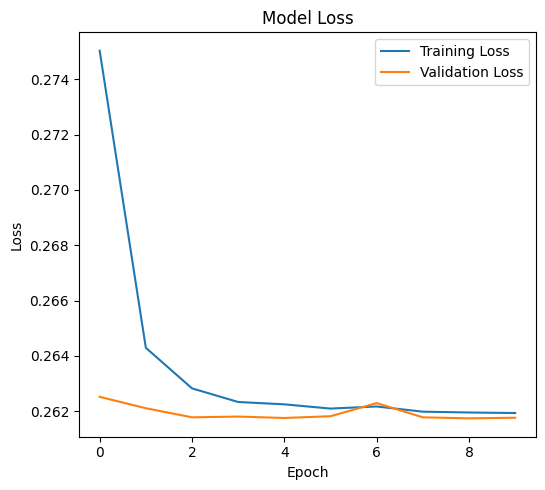

In [ ]:
## 7. Training Visualization

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Evaluating model...

Final Model Performance:
Training Accuracy: 0.9275
Validation Accuracy: 0.9275
Test Accuracy: 0.5520

TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

       maybe       0.00      0.00      0.00        55
          no       0.00      0.00      0.00       169
         yes       0.55      1.00      0.71       276

    accuracy                           0.55       500
   macro avg       0.18      0.33      0.24       500
weighted avg       0.30      0.55      0.39       500



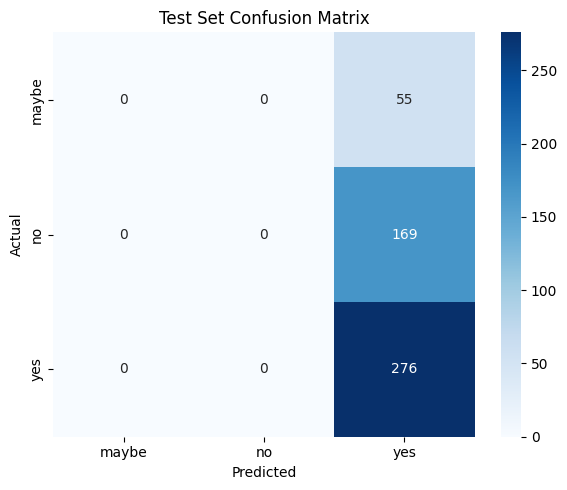

<Figure size 640x480 with 0 Axes>

In [ ]:
## 8. Model Evaluation
## 8. Model Evaluation
def evaluate_model(model, data_loader, device):
    """Evaluate model on given data loader"""
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    return all_preds, all_targets

# Evaluate on all datasets
print("Evaluating model...")
test_preds, test_targets = evaluate_model(model, test_loader, device)

# Calculate accuracies
test_accuracy = accuracy_score(test_targets, test_preds)

print(f"\nFinal Model Performance:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

## 9. Detailed Evaluation Metrics
print("\n" + "="*50)
print("TEST SET CLASSIFICATION REPORT")
print("="*50)
print(classification_report(test_targets, test_preds,
                          target_names=le.classes_))

# Test confusion matrix
cm_test = confusion_matrix(test_targets, test_preds)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_, ax=ax)

ax.set_title('Test Set Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()




### BiLSTM and PubMedBert

In [ ]:
# Load data
df = pd.read_parquet(
    "hf://datasets/qiaojin/PubMedQA/pqa_artificial/train-00000-of-00001.parquet"
)

In [ ]:
df_test = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_labeled/train-00000-of-00001.parquet")


In [ ]:
def clean_dict(d):
    return {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in d.items()}

df['context'] = df['context'].apply(clean_dict)
df_test['context'] = df_test['context'].apply(clean_dict)

In [ ]:
# Encode labels
le = LabelEncoder()
df['final_decision'] = le.fit_transform(df['final_decision'])
df_test['final_decision'] = le.fit_transform(df_test['final_decision'])


In [ ]:
# Stratified sampling 500 for training and 500 for testing
df_sampled = df_test.groupby('final_decision', group_keys=False).apply(lambda x: x.sample(frac=500/len(df_test), random_state=42))

# Remaining data
df_remaining = df_test.drop(df_sampled.index)

df_sampled = Dataset.from_pandas(df_sampled.reset_index(drop=True))
df_remaining = Dataset.from_pandas(df_remaining.reset_index(drop=True))

In [ ]:
df_sampled = df_sampled.to_pandas()

In [ ]:
#df for training
df = pd.concat([df, df_sampled])

In [ ]:
df_remaining = df_remaining.to_pandas()

In [ ]:
df['input_text'] = df.apply(
    lambda row: row['question'] + ' [SEP] ' + ' '.join(row['context']['contexts']) + ' [SEP] ' + row['long_answer'],
    axis=1
)
df_remaining['input_text'] = df_remaining.apply(
    lambda row: row['question'] + ' [SEP] ' + ' '.join(row['context']['contexts']) + ' [SEP] ' + row['long_answer'],
    axis=1
)


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['final_decision'])


In [ ]:
train_df = train_df[['input_text', 'final_decision']]
val_df = val_df[['input_text', 'final_decision']]


In [ ]:
df_test = df_remaining[['input_text', 'final_decision']]

In [ ]:
train_df = train_df.rename(columns={'final_decision': 'labels'})
val_df = val_df.rename(columns={'final_decision': 'labels'})
test_df = df_test.rename(columns={'final_decision': 'labels'})


In [ ]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Use PubMedBERT - abstracts only
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)
bert_model.eval()  # freeze BERT
for param in bert_model.parameters():
    param.requires_grad = False

In [ ]:
def tokenize_fn(examples):
    return tokenizer(
        examples["input_text"],
        truncation=True,
        padding="max_length",
        max_length=256,
        return_tensors=None
    )


In [ ]:
tokenized_train = train_dataset.map(tokenize_fn, batched=True)
tokenized_val = val_dataset.map(tokenize_fn, batched=True)
tokenized_test = test_dataset.map(tokenize_fn, batched=True)

In [ ]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, dropout=0.3):
        super(BiLSTMClassifier, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state  # shape: (batch, seq_len, 768)
        lstm_out, _ = self.lstm(embeddings)  # (batch, seq_len, 2*hidden)
        pooled = torch.mean(lstm_out, dim=1)  # (batch, 2*hidden)
        out = self.dropout(pooled)
        return self.fc(out)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMClassifier(bert_model, hidden_dim=128, output_dim=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
try:
    model = torch.compile(model)
except Exception as e:
    print(f"torch.compile not available or failed: {e}")

# Collate function to handle padding
def collate_fn(batch):
    input_ids = pad_sequence([torch.tensor(item['input_ids']) for item in batch], batch_first=True)
    attention_mask = pad_sequence([torch.tensor(item['attention_mask']) for item in batch], batch_first=True)
    labels = torch.tensor([item['labels'] for item in batch])
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}


# Optimized DataLoader
train_loader = DataLoader(
    tokenized_train,
    batch_size=32,  # adjust based on your hardware
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True
)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Checkpoint directory
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

#model.to(device)
model.train()
for epoch in range(5):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} complete, Avg Loss: {avg_loss:.4f}")

    # Save checkpoint every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_metrics(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    report = classification_report(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print("Evaluation Results:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nClassification Report:")
    print(report)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1


In [ ]:
try:
    model = torch.compile(model)
except Exception as e:
    print(f"torch.compile not available or failed: {e}")

# Collate function to handle padding
def collate_fn(batch):
    input_ids = pad_sequence([torch.tensor(item['input_ids']) for item in batch], batch_first=True)
    attention_mask = pad_sequence([torch.tensor(item['attention_mask']) for item in batch], batch_first=True)
    labels = torch.tensor([item['labels'] for item in batch])
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}


# Optimized DataLoader
train_loader = DataLoader(
    tokenized_train,
    batch_size=32,  # adjust based on your hardware
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True
)

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Checkpoint directory
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

#model.to(device)
model.train()
for epoch in range(5):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} complete, Avg Loss: {avg_loss:.4f}")

    # Save checkpoint every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")


/tmp/ipykernel_35/2657905246.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1:   0%|          | 0/4633 [00:00<?, ?it/s]/tmp/ipykernel_35/2657905246.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
W0524 13:26:41.692000 35 torch/_inductor/utils.py:1137] [0/0_1] Not enough SMs to use max_autotune_gemm mode
Epoch 1:   0%|          | 1/4633 [00:23<30:28:04, 23.68s/it, loss=1.25]/tmp/ipykernel_35/2657905246.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 complete, Avg Loss: 0.2696


Epoch 2:   0%|          | 0/4633 [00:00<?, ?it/s]/tmp/ipykernel_35/2657905246.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2 complete, Avg Loss: 0.2640
Checkpoint saved at ./checkpoints/model_epoch_2.pt


Epoch 3 complete, Avg Loss: 0.2625


Epoch 4 complete, Avg Loss: 0.2615
Checkpoint saved at ./checkpoints/model_epoch_4.pt


Epoch 5 complete, Avg Loss: 0.2603


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

Evaluation Results:
Accuracy : 0.3380
Precision: 0.1127
Recall   : 0.3333
F1-score : 0.1684

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.34      1.00      0.51       169
           2       0.00      0.00      0.00       276

    accuracy                           0.34       500
   macro avg       0.11      0.33      0.17       500
weighted avg       0.11      0.34      0.17       500



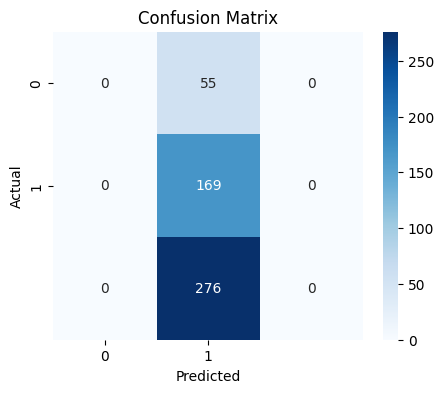

(0.338, 0.11266666666666668, 0.3333333333333333, 0.16841056302939714)

In [ ]:
evaluate_metrics(model, test_loader, device)

This last model did not perform better than the LSTM one.

### DRAGON: Deep Bidirectional Language-Knowledge Graph Pretraining

This model is an improvement with respect to BERT . [DRAGON](https://github.com/michiyasunaga/dragon) is pre-trained jointly from text and knowledge graphs for improved language, knowledge and reasoning capabilities.

We selected this model because it is ranked 19th on the PubMedQA [leaderboard](https://pubmedqa.github.io/). Among the listed models, we found DRAGON to offer the best trade-off between performance and parameter count, making it the most suitable candidate for reproduction given our limited resources.




In [ ]:
# Load artificial data
df = pd.read_parquet(
    "hf://datasets/qiaojin/PubMedQA/pqa_artificial/train-00000-of-00001.parquet"
)

In [ ]:
# Load labeled data
df_labeled = pd.read_parquet(
    "hf://datasets/qiaojin/PubMedQA/pqa_labeled/train-00000-of-00001.parquet"
)

In [ ]:
def clean_dict(d):
    return {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in d.items()}


df["context"] = df["context"].apply(clean_dict)
df_labeled["context"] = df_labeled["context"].apply(clean_dict)

In [ ]:
# Stratified sampling 500 for training and 500 for testing
df_sampled = df_labeled.groupby("final_decision", group_keys=False).apply(
    lambda x: x.sample(frac=500 / len(df_labeled), random_state=42)
)

# Remaining data
df_test = df_labeled.drop(df_sampled.index)

df_sampled = Dataset.from_pandas(df_sampled.reset_index(drop=True))
df_test = Dataset.from_pandas(df_test.reset_index(drop=True))

In [ ]:
df = pd.concat([df, df_sampled])

In [ ]:
df["input_text"] = df.apply(
    lambda row: row["question"]
    + " [SEP] "
    + " ".join(row["context"]["contexts"])
    + " [SEP] "
    + row["long_answer"],
    axis=1,
)

# Testing with long answer (auxiliary supervison)
df_test_as["input_text"] = df_test.apply(
    lambda row: row["question"]
    + " [SEP] "
    + " ".join(row["context"]["contexts"])
    + " [SEP] "
    + row["long_answer"],
    axis=1,
)

# Testing without long answer
df_test["input_text"] = df_test.apply(
    lambda row: row["question"] + " [SEP] " + " ".join(row["context"]["contexts"]),
    axis=1,
)

In [ ]:
# Encode labels
le = LabelEncoder()
df["final_decision"] = le.fit_transform(df["final_decision"])
df_test_as["final_decision"] = le.fit_transform(df_test_as["final_decision"])
df_test["final_decision"] = le.fit_transform(df_test["final_decision"])

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["input_text"], df["final_decision"], test_size=0.2, random_state=42
)

test_texts_as = df_test_as["input_text"]
test_labels_as = df_test_as["final_decision"]

test_texts = df_test["input_text"]
test_labels = df_test["final_decision"]

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

In [ ]:
# Load model from disk
state_dict = torch.load(str(ROOT_PATH  / "biomed_model.pt"), map_location="cpu")

In [ ]:
# Load model from disk
model.bert.load_state_dict(state_dict, strict=False)

In [ ]:
# Tokenization function
def tokenize(batch):
    return tokenizer(
        batch["text"], padding="max_length", truncation=True, max_length=512
    )


train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})
test_dataset_as = Dataset.from_dict({"text": test_texts_as, "label": test_labels_as})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})


train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset_as = test_dataset_as.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Freeze all BERT layers
for param in model.bert.parameters():
    param.requires_grad = False

# Unfreeze last encoder layer and pooler
for param in model.bert.encoder.layer[-2:].parameters():
    param.requires_grad = True

if hasattr(model.bert, "pooler"):
    for param in model.bert.pooler.parameters():
        param.requires_grad = True

In [ ]:
# Compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True,
    disable_tqdm=False,
    dataloader_num_workers=4,
)


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Fine-tune
trainer.train()

# Evaluate
results = trainer.evaluate()
print(results)

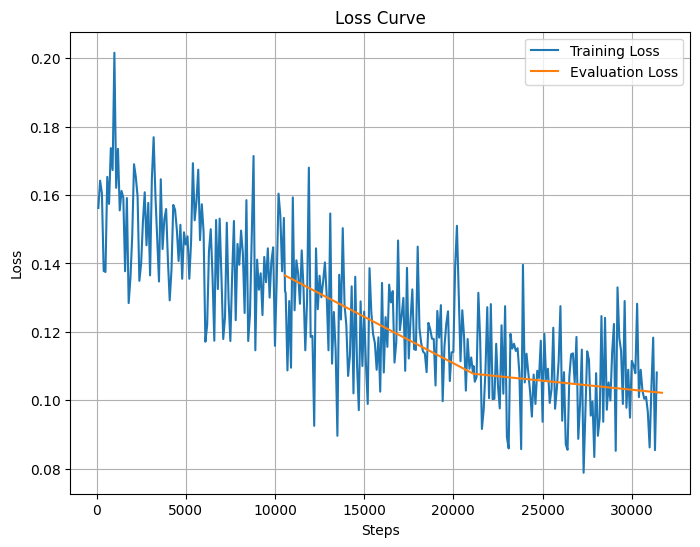

In [ ]:
def plot_loss_curve(trainer):
    logs = trainer.state.log_history

    # Extract steps, training loss, and eval loss
    steps = []
    train_loss = []
    eval_loss = []

    for log in logs:
        if 'loss' in log:
            steps.append(log['step'])
            train_loss.append(log['loss'])
        if 'eval_loss' in log:
            steps.append(log['step'])
            eval_loss.append(log['eval_loss'])

    plt.figure(figsize=(8, 6))

    if train_loss:
        plt.plot(steps[:len(train_loss)], train_loss, label='Training Loss')
    if eval_loss:
        # Adjust for the fact eval_loss is logged at different steps
        eval_steps = [log['step'] for log in logs if 'eval_loss' in log]
        eval_losses = [log['eval_loss'] for log in logs if 'eval_loss' in log]
        plt.plot(eval_steps, eval_losses, label='Evaluation Loss')

    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot after training
plot_loss_curve(trainer)


We have no evident overfitting as the two loss curves follow the same trend.

In [ ]:
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Accuracy: 0.7899
Precision: 0.7641
Recall: 0.9565
F1 Score: 0.8496

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.52      0.65       338
           1       0.76      0.96      0.85       552

    accuracy                           0.79       890
   macro avg       0.82      0.74      0.75       890
weighted avg       0.81      0.79      0.77       890



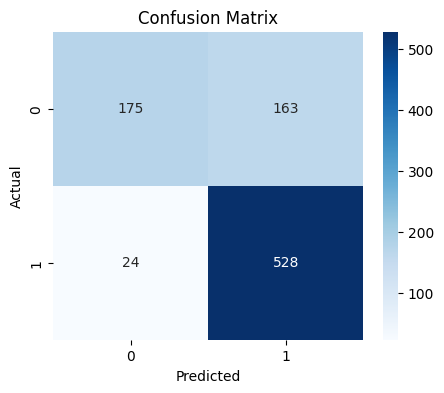

In [ ]:
#Binary classification metrics
def evaluate_on_test_set(model, dataset, tokenizer):
    model.eval()

    dataloader = DataLoader(dataset, batch_size=16)
    all_preds = []
    all_labels = []

    with torch.no_grad():
         for batch in dataloader:
            # If dataset returns dict, ensure you move inputs to device
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
            labels = batch['label'].to(device)

            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    preds = np.array(all_preds)
    labels = np.array(all_labels)


    labels = np.array(test_labels)
    acc = accuracy_score(test_labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, preds, average='binary')
    report = classification_report(test_labels, preds)
    cm = confusion_matrix(test_labels, preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(report)

    # Confusion Matrix plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# ✅ Run custom evaluation on test set
evaluate_on_test_set(model, test_dataset, tokenizer)

We are now going to show that that the model struggles more in predicting the class 0 correctly due to class imbalance.

In [ ]:
DRAGON_PATH = str(ROOT_PATH  / "DRAGON")
DRAGON_FINETUNE_PATH = str(ROOT_PATH  / "DRAGON-finetune")

In [ ]:
# Save the best model
trainer.save_model(
    DRAGON_PATH,
)  # Will save model, config, tokenizer

# Also save tokenizer
tokenizer.save_pretrained(DRAGON_PATH)

In [ ]:
# Load model and tokenizer for 3 class evaluation
model = BertForSequenceClassification.from_pretrained(
    DRAGON_PATH,
    num_labels=3,
    ignore_mismatched_sizes=True,
)
tokenizer = BertTokenizer.from_pretrained(DRAGON_PATH)


# Define training arguments
training_args = TrainingArguments(
    output_dir=DRAGON_FINETUNE_PATH,
    eval_strategy="no",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    save_steps=50,
    logging_steps=10,
    save_total_limit=1,
    overwrite_output_dir=True,
)


# Initialize Trainer
trainer = Trainer(
    model=model, args=training_args, train_dataset=df, tokenizer=tokenizer
)

# Fine-tune the model
trainer.train()

In [ ]:
# 3 class classification metrics
def evaluate_on_test_set(model, dataset, tokenizer, true_labels):
    model.eval()

    dataloader = DataLoader(dataset, batch_size=16)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {}
            for k, v in batch.items():
                if k != "label":
                    if isinstance(v, list) and isinstance(v[0], str):
                        # Tokenize and move to device
                        encoded = tokenizer(
                            v, padding=True, truncation=True, return_tensors="pt"
                        ).to(device)
                        inputs.update(encoded)
                    elif isinstance(v, torch.Tensor):
                        inputs[k] = v.to(device)
                    else:
                        pass  # handle other cases

            labels = batch["label"].to(device)

            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    preds = np.array(all_preds)
    labels = np.array(all_labels)

    # labels = np.array(test_labels)
    acc = accuracy_score(true_labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, preds, average="weighted"
    )
    report = classification_report(true_labels, preds)
    cm = confusion_matrix(true_labels, preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(report)

    # Confusion Matrix plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1]
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Accuracy: 0.7440
Precision: 0.6615
Recall: 0.7440
F1 Score: 0.7000

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.72      0.76      0.74       169
           2       0.76      0.88      0.81       276

    accuracy                           0.74       500
   macro avg       0.49      0.55      0.52       500
weighted avg       0.66      0.74      0.70       500



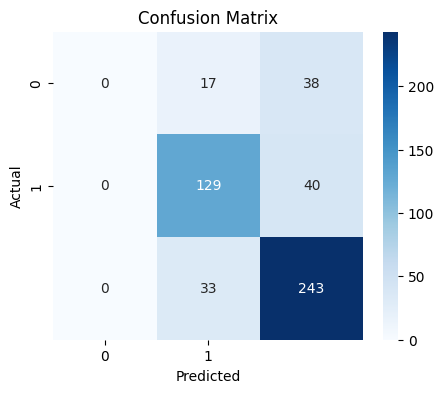

In [ ]:
evaluate_on_test_set(model, test_dataset_as, tokenizer, test_labels_as)

Accuracy: 0.6180
Precision: 0.5545
Recall: 0.6180
F1 Score: 0.5839

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.53      0.65      0.59       169
           2       0.68      0.72      0.70       276

    accuracy                           0.62       500
   macro avg       0.40      0.46      0.43       500
weighted avg       0.55      0.62      0.58       500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

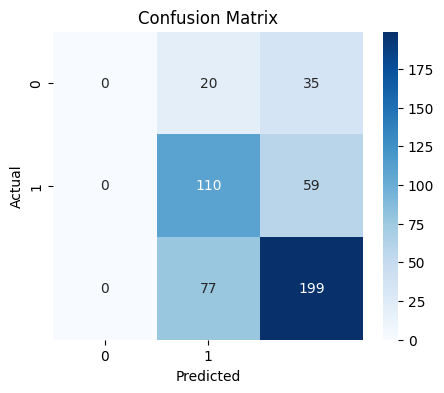

In [ ]:
evaluate_on_test_set(model, test_dataset, tokenizer)

As an experiment aimed at aligning our results more closely with those on the leaderboard, we attempted to include the "maybe" class in our predictions. However, due to the limited number of samples (only 110), the model struggled to classify this class accurately. Despite this, we achieved an overall accuracy of 74%—matching the leaderboard result exactly.

Another interesting finding, inspired by the original paper, was the performance difference when the model was run with and without access to the long_answer. As expected, excluding the long_answer led to a noticeable drop in accuracy—specifically, by 12%.

### Two-Phase Fine-Tuning



In this section we describe a two-step fine-tuning approach applied to the PubMedBERT model.

In the first phase, the model is trained as a binary classifier using the artificial training set composed exclusively of short answers labeled "yes" or "no". This helps the model develop a solid foundation in handling clear binary classifications.

In the second phase, the model is further fine-tuned on the labeled dataset, which is significantly smaller but includes the additional "maybe" class.

In [ ]:
labeled_df = load("labeled")
artificial_df = load("artificial")


In [ ]:
# test labeled data filtered (without maybe)
test_filtered_df = test_df[test_df["test_ground_truth"].isin(["yes", "no"])]


In [ ]:
le = LabelEncoder()
le.classes_ = np.array(["no", "yes", "maybe"])  # Ensure fixed class order




# Labeled training data
labeled_train_set["final_decision_encoded"] = le.transform(labeled_train_set["final_decision_str"])

# Test data (full and filtered)
test_df["final_decision_encoded"] = le.transform(test_df["test_ground_truth"])
test_filtered_df["final_decision_encoded"] = le.transform(test_filtered_df["test_ground_truth"])

# Artificial training data
artificial_df["final_decision_encoded"] = le.transform(artificial_df["final_decision_str"])


<ipython-input-38-97b8de242c62>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered_df["final_decision_encoded"] = le.transform(test_filtered_df["test_ground_truth"])


In [ ]:
# Without reasoning
test_df_no_Reasoning = test_df.copy()
test_df_no_Reasoning["input_text"] = test_df_no_Reasoning["no_reasoning"]

In [ ]:
# With reasoning
artificial_df["input_text"] = artificial_df["full_text"]
labeled_train_set["input_text"] = labeled_train_set["full_text"]
test_df["input_text"] = test_df["full_text"]
test_filtered_df["input_text"] = test_filtered_df["full_text"]


<ipython-input-40-d64f6d581119>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filtered_df["input_text"] = test_filtered_df["full_text"]


In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

def preprocess_function(example):
    tokenized = tokenizer(example['input_text'], truncation=True, padding='max_length', max_length=512)
    return {
        'input_ids': tokenized['input_ids'],
        'attention_mask': tokenized['attention_mask'],
        'token_type_ids': tokenized.get('token_type_ids'),
        'final_decision_encoded': example['final_decision_encoded']
    }


In [ ]:
# --- 2. Apply tokenization to all datasets ---
artificial_df = artificial_df.apply(preprocess_function, axis=1, result_type="expand")
labeled_train_set= labeled_train_set.apply(preprocess_function, axis=1, result_type='expand')
test_df = test_df.apply(preprocess_function, axis=1, result_type='expand')
test_filtered_df = test_filtered_df.apply(preprocess_function, axis=1, result_type='expand')
test_df_no_Reasoning = test_df_no_Reasoning.apply(preprocess_function, axis=1, result_type='expand')

In [ ]:
# First split into train (80%) and temp (20%)
artificial_train, artificial_temp = train_test_split(
    artificial_df,
    test_size=0.2,
    random_state=42,
    stratify=artificial_df["final_decision_encoded"],
)

# Split temp into val (10%) and test (10%)
artificial_val, artificial_test = train_test_split(
    artificial_temp,
    test_size=0.5,
    random_state=42,
    stratify=artificial_temp["final_decision_encoded"],
)

To ensure a fair comparison, we now need to create a subset of the artificial dataset that mirrors the class distribution of the labeled_filtered dataset (i.e., the labeled dataset excluding "maybe" answers), maintaining the same number of "yes" and "no" samples.

This allows us to evaluate the model on both datasets without introducing bias from dataset size or class imbalance. Since the original artificial test set is much larger and skewed toward the "yes" class, relying on it alone could inflate the model's performance by underrepresenting "no" cases and reducing the impact of their misclassification.

In [ ]:
# Get the label distribution from the filtered real dataset
distribution = test_filtered_df['final_decision_encoded'].value_counts(normalize=True)

# Total number of samples to match
n_total = len(test_filtered_df)

# Correctly assign sample counts for each class based on label encoding
n_yes = int(distribution[1] * n_total)
n_no = n_total - n_yes

print(f"Samples needed: no = {n_no}, yes = {n_yes}")

# Sample from artificial test set accordingly
artificial_yes = artificial_test[artificial_test['final_decision_encoded'] == 1].sample(n=n_yes, random_state=42)
artificial_no = artificial_test[artificial_test['final_decision_encoded'] == 0].sample(n=n_no, random_state=42)

# Concatenate and shuffle
artificial_test_balanced = pd.concat([artificial_no, artificial_yes], ignore_index=True)
artificial_test_balanced = artificial_test_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Confirm distribution and total size
print(artificial_test_balanced['final_decision_encoded'].value_counts())
print(f"Total samples: {len(artificial_test_balanced)}")
print(artificial_test_balanced['final_decision_encoded'].value_counts(normalize=True))

Samples needed: no = 169, yes = 276
final_decision_encoded
1    276
0    169
Name: count, dtype: int64
Total samples: 445
final_decision_encoded
1    0.620225
0    0.379775
Name: proportion, dtype: float64


In [ ]:
from torch.utils.data import Dataset
class QA_Dataset(Dataset):
    def __init__(self, df):
        self.input_ids = df["input_ids"].tolist()
        self.attention_mask = df["attention_mask"].tolist()
        self.labels = df["final_decision_encoded"].astype(int).tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.tensor(self.attention_mask[idx], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

In [ ]:
# Wrap in your dataset class
labeled_train = QA_Dataset(labeled_train_set)
labeled_test = QA_Dataset(test_df)


artificial_train = QA_Dataset(artificial_train)
artificial_val = QA_Dataset(artificial_val)
artificial_test = QA_Dataset(artificial_test)

artificial_test_balanced = QA_Dataset(artificial_test_balanced)

ds_labeled_filtered = QA_Dataset(test_filtered_df)

labeled_test_no_reasoning = QA_Dataset(test_df_no_Reasoning)

In [ ]:
model_checkpoint = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2
)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# === FREEZE UTILS ===
def freeze_bert_layers(model, keep_last_n=4):
    """
    Freezes all BERT layers except the last `n` encoder layers and the pooler.
    """
    assert hasattr(model, "bert"), "Model must have a 'bert' attribute"
    for name, param in model.bert.named_parameters():
        if (
            not any(f"encoder.layer.{i}" in name for i in range(12 - keep_last_n, 12))
            and "pooler" not in name
        ):
            param.requires_grad = False


def unfreeze_all_bert_layers(model):
    """
    Unfreezes all BERT layers.
    """
    for param in model.bert.parameters():
        param.requires_grad = True

In [ ]:
# Freeze all but the last 4 layers
freeze_bert_layers(model, keep_last_n=4)

In [ ]:
def compute_metrics_binary(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)  # Assumes num_labels=2

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="binary", zero_division=0),
        "precision": precision_score(labels, preds, average="binary", zero_division=0),
        "recall": recall_score(labels, preds, average="binary", zero_division=0),
    }


In [ ]:
training_args = TrainingArguments(
    output_dir=str(ROOT_PATH  / "pubmedqa_finetune_pubmedbert"),
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    report_to="tensorboard",  # Optional for TensorBoard logging
    logging_dir=str(ROOT_PATH  / "pubmedqa_finetune_pubmedbert"),
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=artificial_train,
    eval_dataset=artificial_val,
    compute_metrics=compute_metrics_binary,
)

In [ ]:
PUBMEDBERT_ARTIFICIAL_PATH = str(ROOT_PATH  / "pubmedqa_finetuned_pubmedbert_artificial")
PUBMEDBERT_FINAL_PATH = str(ROOT_PATH  / "pubmedqa_finetune_PubMedBERT_final")
PUBMEDBERT_LABELED_PATH = str(ROOT_PATH  / 'pubmedqa_finetuned_PubMedBERT_labeled')

In [ ]:
# Train the model using Trainer
trainer.train()

# Save the model and tokenizer to a specific directory
output_dir = PUBMEDBERT_ARTIFICIAL_PATH

# Save the trained model
model.save_pretrained(output_dir)

# Save the tokenizer (very important to reload later correctly)
tokenizer.save_pretrained(output_dir)

print(f"\n✅ Fine-tuned model and tokenizer saved to: {output_dir}")



✅ Fine-tuned model and tokenizer saved to: /content/drive/MyDrive/pubmedqa_finetuned_pubmedbert_artificial


We now perform predictions using the artificial test dataset.

Unique predictions: [0 1]

✅ Classification Report (Binary):
              precision    recall  f1-score   support

          no     0.6826    0.4719    0.5580      1513
         yes     0.9602    0.9831    0.9715     19614

    accuracy                         0.9465     21127
   macro avg     0.8214    0.7275    0.7648     21127
weighted avg     0.9403    0.9465    0.9419     21127



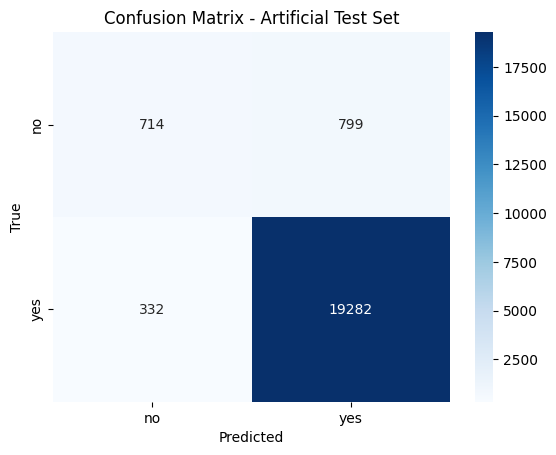

In [ ]:
# Run prediction on artificial test
predictions = trainer.predict(artificial_test)

logits = predictions.predictions
labels = predictions.label_ids

# Predict using argmax over logits
preds = logits.argmax(axis=-1)

# Verify predictions
import numpy as np
print("Unique predictions:", np.unique(preds))

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n✅ Classification Report (Binary):")
print(classification_report(labels, preds, labels=[0, 1], target_names=['no', 'yes'], digits=4))

cm = confusion_matrix(labels, preds, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.title("Confusion Matrix - Artificial Test Set")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Next, we evaluate the model on the balanced artificial dataset we previously created to match the distribution of the labeled data.

Unique predictions: [0 1]

✅ Classification Report (Binary):
              precision    recall  f1-score   support

          no     0.9195    0.4734    0.6250       169
         yes     0.7514    0.9746    0.8486       276

    accuracy                         0.7843       445
   macro avg     0.8355    0.7240    0.7368       445
weighted avg     0.8153    0.7843    0.7637       445



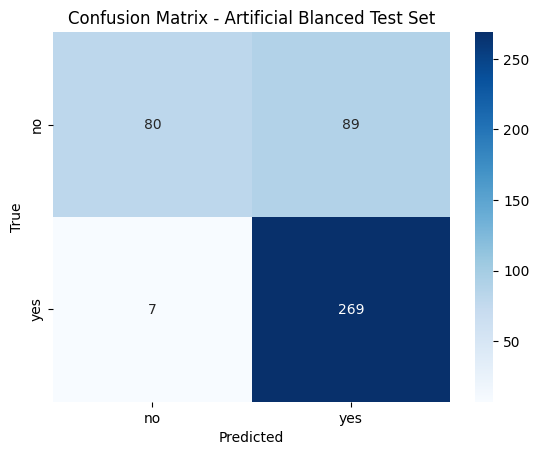

In [ ]:
# Run prediction on artificial test balanced
predictions = trainer.predict(artificial_test_balanced)

logits = predictions.predictions
labels = predictions.label_ids

# Predict using argmax over logits
preds = logits.argmax(axis=-1)

# Verify predictions
import numpy as np
print("Unique predictions:", np.unique(preds))

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n✅ Classification Report (Binary):")
print(classification_report(labels, preds, labels=[0, 1], target_names=['no', 'yes'], digits=4))

cm = confusion_matrix(labels, preds, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.title("Confusion Matrix - Artificial Blanced Test Set")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Finally, we perform predictions on the filtered labeled dataset, which excludes the 'maybe' class.



Unique predictions: [0 1]

✅ Classification Report (Binary):
              precision    recall  f1-score   support

          no     0.9444    0.3018    0.4574       169
         yes     0.6982    0.9891    0.8186       276

    accuracy                         0.7281       445
   macro avg     0.8213    0.6455    0.6380       445
weighted avg     0.7917    0.7281    0.6814       445



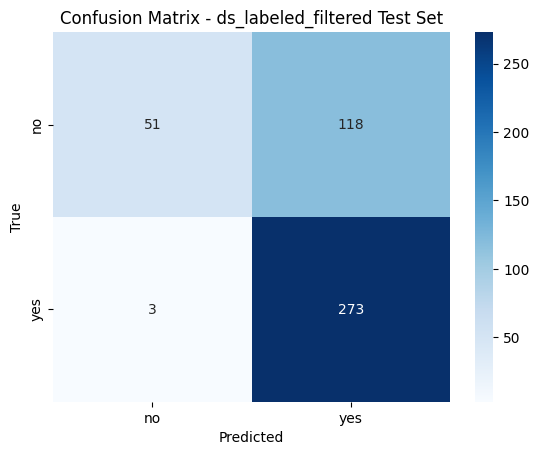

In [ ]:
predictions = trainer.predict(ds_labeled_filtered)

logits = predictions.predictions
labels = predictions.label_ids

# Predict using argmax over logits
preds = logits.argmax(axis=-1)

# Verify predictions
import numpy as np
print("Unique predictions:", np.unique(preds))

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n✅ Classification Report (Binary):")
print(classification_report(labels, preds, labels=[0, 1], target_names=['no', 'yes'], digits=4))

cm = confusion_matrix(labels, preds, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.title("Confusion Matrix - ds_labeled_filtered Test Set")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

We can clearly observe that the model performs significantly better on the full artificial dataset. This is expected, as the dataset is large and heavily imbalanced toward the "yes" class, which likely skews the results in the model’s favor.

Another interesting observation: when comparing the balanced artificial dataset with the filtered labeled dataset, the model still performs better on the artificial data. This suggests that the model is more adapted to the distribution and patterns of the synthetic examples, likely because it was fine-tuned exclusively on artificial data up to this point, rather than on expert-annotated examples.

However, we still observe difficulties in accurately predicting the "no" class

We now begin the second phase of fine-tuning. In this stage, we further train the previously fine-tuned model using the labeled dataset, which includes instances of the "maybe" class. As a result, the model transitions from a binary classifier to a three-class classifier capable of predicting "yes", "no", or "maybe" answers.



In [ ]:
# Load the original config and override num_labels to 3
config = AutoConfig.from_pretrained(
    PUBMEDBERT_ARTIFICIAL_PATH,
)
config.num_labels = 3

# Load the model and update to 3-class output head
model_3class = AutoModelForSequenceClassification.from_pretrained(
    PUBMEDBERT_ARTIFICIAL_PATH,
    config=config,
    ignore_mismatched_sizes=True  # Allows resizing the classification head
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PUBMEDBERT_ARTIFICIAL_PATH,)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/pubmedqa_finetuned_pubmedbert_artificial and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics_3class(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro'),
        'f1_weighted': f1_score(labels, preds, average='weighted'),
        'precision_macro': precision_score(labels, preds, average='macro'),
        'recall_macro': recall_score(labels, preds, average='macro')
    }

In [ ]:
from transformers import TrainingArguments, Trainer

training_args_final = TrainingArguments(
    output_dir=PUBMEDBERT_FINAL_PATH,
    save_strategy='epoch',
    logging_strategy='epoch',
    eval_strategy='no',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to='tensorboard',
    logging_dir=PUBMEDBERT_FINAL_PATH
)

In [ ]:
trainer_final = Trainer(
    model=model_3class,
    args=training_args_final,
    train_dataset=labeled_train,
    compute_metrics=compute_metrics_3class
)

In [ ]:
# Train the model using Trainer
trainer_final.train()

# Save the model and tokenizer to a specific directory
output_dir = PUBMEDBERT_LABELED_PATH

# Save the trained model
model_3class.save_pretrained(output_dir)


# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print(f"\n✅ Fine-tuned model and tokenizer saved to: {output_dir}")


✅ Fine-tuned model and tokenizer saved to: /content/drive/MyDrive/pubmedqa_finetuned_PubMedBERT_labeled


We now evaluate the three-class model on the test labeled dataset to assess its performance across all answer types: "yes", "no", and "maybe".

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


✅ Classification Report on Labeled Test Set:

              precision    recall  f1-score   support

          no     0.6319    0.6805    0.6553       169
         yes     0.7138    0.8225    0.7643       276
       maybe     0.0000    0.0000    0.0000        55

    accuracy                         0.6840       500
   macro avg     0.4486    0.5010    0.4732       500
weighted avg     0.6076    0.6840    0.6434       500



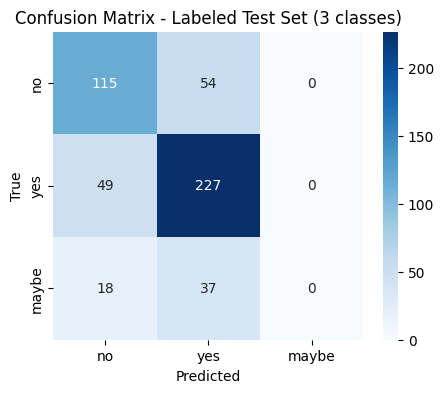

In [ ]:
# Get raw predictions on the test set
predictions = trainer_final.predict(labeled_test)

# Extract logits and true labels
logits = predictions.predictions
labels = predictions.label_ids

# Get predicted classes
preds = logits.argmax(axis=-1)

# Safe conversion to string class names
report = classification_report(labels, preds, target_names=[str(c) for c in le.classes_], digits=4)

print("\n✅ Classification Report on Labeled Test Set:\n")
print(report)

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot with correct class labels
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Labeled Test Set (3 classes)')
plt.show()

We observe that the model still struggles to correctly predict the "maybe" class. Although it was fine-tuned on a dataset that includes "maybe" instances, the limited number of examples for this class hinders the model's ability to learn its patterns effectively.

As a result, the overall performance of the classifier has decreased compared to the binary version. This drop is expected due to the increased complexity introduced by adding a third class and the imbalance in class representation, particularly the scarcity of "maybe" examples.

We also evaluate the model on the labeled_no_reasoning test set, which is identical to the labeled test set but excludes the long_answer column. This allows us to verify whether the model's performance relies on the presence of detailed explanations or can generalize based on the question and the context input features.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



✅ Classification Report on Labeled Test Set:

              precision    recall  f1-score   support

          no     0.5584    0.5089    0.5325       169
         yes     0.6387    0.8007    0.7106       276
       maybe     0.0000    0.0000    0.0000        55

    accuracy                         0.6140       500
   macro avg     0.3991    0.4365    0.4144       500
weighted avg     0.5413    0.6140    0.5722       500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


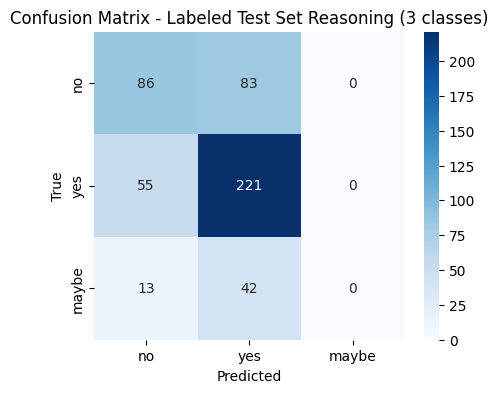

In [ ]:
# Get raw predictions on the labeled test set without the long answer (no reasoning)
predictions = trainer_final.predict(labeled_test_no_reasoning)

# Extract logits and true labels
logits = predictions.predictions
labels = predictions.label_ids

# Get predicted classes
preds = logits.argmax(axis=-1)

# Safe conversion to string class names
report = classification_report(labels, preds, target_names=[str(c) for c in le.classes_], digits=4)

print("\n✅ Classification Report on Labeled Test Set:\n")
print(report)

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot with correct class labels
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Labeled Test Set Reasoning (3 classes)')
plt.show()

The decline of the performance is due to the absence of the long_answer field, which previously provided rich contextual information to support the model’s predictions. Without it, the model has less information to base its decisions on.

### LLM inference

In [ ]:
llm_outputs = defaultdict(dict)
for path in LLM_OUTPUT_ROOT_DIR.rglob("*.pkl"):
    with path.open("rb") as f:
        llm_outputs[str(path.relative_to(LLM_OUTPUT_ROOT_DIR))] = pickle.load(f)
llm_outputs.keys()

dict_keys(['Qwen2.5-1.5B-Instruct/conclusion-cot.pkl', 'Qwen2.5-1.5B-Instruct/conclusion-cot-multiple-choice-numbers.pkl', 'Qwen2.5-1.5B-Instruct/zeroshot-multiple-choice-numbers.pkl', 'Qwen2.5-1.5B-Instruct/zeroshot.pkl', 'Qwen2.5-1.5B-Instruct/conclusion-zeroshot.pkl', 'Qwen2.5-1.5B-Instruct/conclusion-rag-cot-multiple-choice-numbers.pkl', 'Qwen2.5-1.5B-Instruct/cot.pkl', 'Qwen2.5-1.5B-Instruct/conclusion-zeroshot-multiple-choice-numbers.pkl', 'Qwen2.5-1.5B-Instruct/cot-multiple-choice-numbers.pkl', 'Qwen2.5-1.5B/conclusion-cot.pkl', 'Qwen2.5-1.5B/conclusion-cot-multiple-choice-numbers.pkl', 'Qwen2.5-1.5B/conclusion-zeroshot.pkl', 'Qwen2.5-1.5B/conclusion-zeroshot-multiple-choice-numbers.pkl', 'DeepSeek-R1-Distill-Qwen-1.5B/conclusion-cot.pkl', 'DeepSeek-R1-Distill-Qwen-1.5B/conclusion-cot-multiple-choice-numbers.pkl', 'DeepSeek-R1-Distill-Qwen-1.5B/zeroshot.pkl', 'DeepSeek-R1-Distill-Qwen-1.5B/conclusion-zeroshot.pkl', 'DeepSeek-R1-Distill-Qwen-1.5B/conclusion-rag-cot-multiple-choic

#### Extract answers

LLMs generate language and not a class label, so we must extract the class label from inside the model output.

The following extraction methods were developer iteratively and empirically, manually analysing model outputs when no prediction could be extracted, and then adding further extraction functions in cases where a semi-structured response could be found.

In [ ]:
EMPHASIS = r"\*\*|\*|\"|\[|\(|\{|\)|\]|\}"
YES_NO_MAYBE = r"(" + EMPHASIS + r")?([123]\)\s*)?(yes|no|maybe)(" + EMPHASIS + r")?"
ONE_TWO_THREE = r"(" + EMPHASIS + r")?()?([123])(" + EMPHASIS + r")?"

In [ ]:
def answer_tag_extractor(output: str, pattern: str) -> str:
    regex = (
        r"("
        + EMPHASIS
        + r")?"
        + r"ANSWER"
        + r"("
        + EMPHASIS
        + r")?"
        + r":"
        + r"("
        + EMPHASIS
        + r")?"
        + r"\s*"
        + pattern
    )
    return re.findall(regex, output, re.IGNORECASE)[0][-2]

In [ ]:
answer_tag_extractor("ANSWER: yes", pattern=YES_NO_MAYBE)

'yes'

In [ ]:
def the_answer_is_extractor(output: str, pattern: str) -> str:
    return re.findall(r"The answer is:?\s+" + pattern, output, re.IGNORECASE)[0][-2]

In [ ]:
the_answer_is_extractor("The answer is: **yes**", YES_NO_MAYBE)

'yes'

In [ ]:
def end_of_think_extractor(output: str, pattern: str) -> str:
    return re.findall(r"<\/think>\s+" + pattern, output, re.IGNORECASE | re.MULTILINE)[
        0
    ][-2]

In [ ]:
end_of_think_extractor("</think>\n(Yes)", YES_NO_MAYBE)

'Yes'

In [ ]:
def immediate_answer_extractor(output: str, pattern: str) -> str:
    first_word = output.split()[0]
    return re.findall(pattern, first_word, re.IGNORECASE)[0][-2]

In [ ]:
immediate_answer_extractor("**Yes**", YES_NO_MAYBE)

'Yes'

In [ ]:
def extract_answer_from_output(
    output: str,
    print_on_error=False,
) -> tuple[str | None, int | None]:
    extractors = [
        partial(extractor, pattern=pattern)
        for extractor in (
            answer_tag_extractor,
            the_answer_is_extractor,
            end_of_think_extractor,
            immediate_answer_extractor,
        )
        for pattern in (YES_NO_MAYBE, ONE_TWO_THREE)
    ]
    for i, extractor in enumerate(extractors):
        try:
            answer = extractor(output).lower()
            extractor_index = i
            break
        except Exception:  # noqa: S112
            continue
    else:
        if print_on_error:
            print("*" * 50)
            print(output[:50])
            print(output[-50:])
            print("*" * 50)
            print()
        return None, None

    if not answer:
        answer = None
    elif answer == "1":
        answer = "yes"
    elif answer == "2":
        answer = "no"
    elif answer == "3":
        answer = "maybe"

    return answer, extractor_index


extract_answer_from_output("ANSWER: Yes")

('yes', 0)

We set `print_on_error` to manually inspect the instances in which no answer was found during extraction development

In [ ]:
def extract_answer_from_outputs(
    experiment_outputs: list[str], print_on_error=False
) -> tuple[list[str | None], list[int], list[int]]:
    answers = []
    extractor_indices = []
    error_indices = []
    for i, output in tqdm(enumerate(experiment_outputs), total=len(experiment_outputs)):
        answer, extractor_index = extract_answer_from_output(output, print_on_error)
        if answer is None:
            error_indices.append(i)
        answers.append(answer)
        extractor_indices.append(extractor_index)
    return answers, extractor_indices, error_indices

In [ ]:
llm_predicted_df_dict = {}
for experiment, experiment_outputs in llm_outputs.items():
    experiment_answers, _, _ = extract_answer_from_outputs(experiment_outputs)
    llm_predicted_df_dict[experiment] = experiment_answers
llm_predicted_df = pd.DataFrame(llm_predicted_df_dict)
llm_predicted_df

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Qwen2.5-1.5B-Instruct/conclusion-cot.pkl  \
0                                        yes   
1                                        yes   
2                                        yes   
3                                        yes   
4                                        yes   
..                                       ...   
995                                      yes   
996                                      yes   
997                                       no   
998                                      yes   
999                                      yes   

    Qwen2.5-1.5B-Instruct/conclusion-cot-multiple-choice-numbers.pkl  \
0                                                   no                 
1                                                 None                 
2                                                  yes                 
3                                                   no                 
4                                                   no                 
..                                                 ...                 
995                                                yes                 
996                                              maybe                 
997                                              maybe                 
998                                                yes                 
999                                                yes                 

    Qwen2.5-1.5B-Instruct/zeroshot-multiple-choice-numbers.pkl  \
0                                                  yes           
1                                                  yes           
2                                                  yes           
3                                                   no           
4                                                  yes           
..                                                 ...           
995                                                yes           
996                                                 no           
997                                                 no           
998                                                yes           
999                                                yes           

    Qwen2.5-1.5B-Instruct/zeroshot.pkl  \
0                                  yes   
1                                  yes   
2                                  yes   
3                                   no   
4                                  yes   
..                                 ...   
995                                yes   
996                                yes   
997                                 no   
998                                yes   
999                                yes   

    Qwen2.5-1.5B-Instruct/conclusion-zeroshot.pkl  \
0                                             yes   
1                                           maybe   
2                                              no   
3                                              no   
4                                             yes   
..                                            ...   
995                                           yes   
996                                           yes   
997                                           yes   
998                                           yes   
999                                            no   

    Qwen2.5-1.5B-Instruct/conclusion-rag-cot-multiple-choice-numbers.pkl  \
0                                                  yes                     
1                                                  yes                     
2                                                  yes                     
3                                                 None                     
4                                                maybe                     
..                                                 ...                     
995                                                yes                     
996                

In [ ]:
llm_predicted_df.replace("", pd.NA).isna().sum()

Qwen2.5-1.5B-Instruct/conclusion-cot.pkl                                         26
Qwen2.5-1.5B-Instruct/conclusion-cot-multiple-choice-numbers.pkl                 77
Qwen2.5-1.5B-Instruct/zeroshot-multiple-choice-numbers.pkl                        0
Qwen2.5-1.5B-Instruct/zeroshot.pkl                                                6
Qwen2.5-1.5B-Instruct/conclusion-zeroshot.pkl                                     3
Qwen2.5-1.5B-Instruct/conclusion-rag-cot-multiple-choice-numbers.pkl             34
Qwen2.5-1.5B-Instruct/cot.pkl                                                    27
Qwen2.5-1.5B-Instruct/conclusion-zeroshot-multiple-choice-numbers.pkl             0
Qwen2.5-1.5B-Instruct/cot-multiple-choice-numbers.pkl                            74
Qwen2.5-1.5B/conclusion-cot.pkl                                                 429
Qwen2.5-1.5B/conclusion-cot-multiple-choice-numbers.pkl                         353
Qwen2.5-1.5B/conclusion-zeroshot.pkl                                        

#### Compute classification metrics

In [ ]:
llm_predicted_df.index = labeled_df.index
llm_predicted_df

Qwen2.5-1.5B-Instruct/conclusion-cot.pkl  \
pubid                                               
21645374                                      yes   
16418930                                      yes   
9488747                                       yes   
17208539                                      yes   
10808977                                      yes   
...                                           ...   
8921484                                       yes   
16564683                                      yes   
23147106                                       no   
21550158                                      yes   
17559449                                      yes   

         Qwen2.5-1.5B-Instruct/conclusion-cot-multiple-choice-numbers.pkl  \
pubid                                                                       
21645374                                                 no                 
16418930                                               None                 
9488747                                                 yes                 
17208539                                                 no                 
10808977                                                 no                 
...                                                     ...                 
8921484                                                 yes                 
16564683                                              maybe                 
23147106                                              maybe                 
21550158                                                yes                 
17559449                                                yes                 

         Qwen2.5-1.5B-Instruct/zeroshot-multiple-choice-numbers.pkl  \
pubid                                                                 
21645374                                                yes           
16418930                                                yes           
9488747                                                 yes           
17208539                                                 no           
10808977                                                yes           
...                                                     ...           
8921484                                                 yes           
16564683                                                 no           
23147106                                                 no           
21550158                                                yes           
17559449                                                yes           

         Qwen2.5-1.5B-Instruct/zeroshot.pkl  \
pubid                                         
21645374                                yes   
16418930                                yes   
9488747                                 yes   
17208539                                 no   
10808977                                yes   
...                                     ...   
8921484                                 yes   
16564683                                yes   
23147106                                 no   
21550158                                yes   
17559449                                yes   

         Qwen2.5-1.5B-Instruct/conclusion-zeroshot.pkl  \
pubid                                                    
21645374                                           yes   
16418930                                         maybe   
9488747                                             no   
17208539                                            no   
10808977                                           yes   
...                                                ...   
8921484                                            yes   
16564683                                           yes   
23147106                                           yes   
21550158                                           yes   
17559449                                            no   

         Qwen2.5-1.5B-Inst

In [ ]:
llm_predicted_df = llm_predicted_df.fillna("?")
llm_predicted_df

Qwen2.5-1.5B-Instruct/conclusion-cot.pkl  \
pubid                                               
21645374                                      yes   
16418930                                      yes   
9488747                                       yes   
17208539                                      yes   
10808977                                      yes   
...                                           ...   
8921484                                       yes   
16564683                                      yes   
23147106                                       no   
21550158                                      yes   
17559449                                      yes   

         Qwen2.5-1.5B-Instruct/conclusion-cot-multiple-choice-numbers.pkl  \
pubid                                                                       
21645374                                                 no                 
16418930                                                  ?                 
9488747                                                 yes                 
17208539                                                 no                 
10808977                                                 no                 
...                                                     ...                 
8921484                                                 yes                 
16564683                                              maybe                 
23147106                                              maybe                 
21550158                                                yes                 
17559449                                                yes                 

         Qwen2.5-1.5B-Instruct/zeroshot-multiple-choice-numbers.pkl  \
pubid                                                                 
21645374                                                yes           
16418930                                                yes           
9488747                                                 yes           
17208539                                                 no           
10808977                                                yes           
...                                                     ...           
8921484                                                 yes           
16564683                                                 no           
23147106                                                 no           
21550158                                                yes           
17559449                                                yes           

         Qwen2.5-1.5B-Instruct/zeroshot.pkl  \
pubid                                         
21645374                                yes   
16418930                                yes   
9488747                                 yes   
17208539                                 no   
10808977                                yes   
...                                     ...   
8921484                                 yes   
16564683                                yes   
23147106                                 no   
21550158                                yes   
17559449                                yes   

         Qwen2.5-1.5B-Instruct/conclusion-zeroshot.pkl  \
pubid                                                    
21645374                                           yes   
16418930                                         maybe   
9488747                                             no   
17208539                                            no   
10808977                                           yes   
...                                                ...   
8921484                                            yes   
16564683                                           yes   
23147106                                           yes   
21550158                                           yes   
17559449                                            no   

         Qwen2.5-1.5B-Inst

In [ ]:
llm_test_df = llm_predicted_df.join(test_df, how="inner")

In [ ]:
for experiment in llm_predicted_df.columns:
    print(experiment)
    print("-"*75)
    print(
        classification_report(
            llm_test_df["test_ground_truth"],
            llm_test_df[experiment],
            zero_division=0,
        )
    )
    print("-"*75)
    print("-"*75)
    print()

Qwen2.5-1.5B-Instruct/conclusion-cot.pkl
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           ?       0.00      0.00      0.00         0
       maybe       0.12      0.04      0.06        55
          no       0.67      0.33      0.44       169
         yes       0.63      0.89      0.74       276

    accuracy                           0.61       500
   macro avg       0.36      0.31      0.31       500
weighted avg       0.59      0.61      0.56       500

---------------------------------------------------------------------------
---------------------------------------------------------------------------

Qwen2.5-1.5B-Instruct/conclusion-cot-multiple-choice-numbers.pkl
---------------------------------------------------------------------------
              precision    recall  f1-score   support

           ?       0.00      0.00      0.00         0
       maybe       0.12      0.11      0.12  